Se tienen $n$ máquinas que deben estar en funcionamiento y $s$ máquinas de repuesto que reemplazan las rotas en el momento que se rompen. Las maquinas rotas tienen un tiempo de reparación que se determina por alguna distribución $G$ y el tiempo de vida de las máquinas se determina por una distribución $F$.

Al romperse una máquina tiene un costo de reparación $c$ y un tiempo de reparación $r$, se puede elegir repararla o comprar una nueva en cuyos casos:

- Si se repara la máquina volverá a estar disponible en el tiempo $r$ habiendo consumido un costo $c$ 
- Si no se repara, se compra una nueva por un costo fijo $C$ y demora un tiempo fijo $R$ en llegar y estar disponible

La fábrica genera dinero continuamente mientras está en funcionamiento a un ritmo $p(t) > 0$ (la fábrica no tiene pérdidas) donde $t$ es el tiempo transcurrido y $p$ una función que define la ganancia. Con esto se dice que la ganancia hasta el momento $t^{*}$ es igual a $P(t^{*}) = \int_{0}^{t^{*}} {p(t)dt}$. En el código $P$ es referida como `profit_function`.

Además, al inicio tiene un presupuesto inicial $f > 0$ al cual se le suman todas las ganancias obtenidas (reinversión total) en todo momento, si en algún momento $f <= 0$, la fábrica quiebra y por lo tanto se detiene la simulación. 

Para decidir si una máquina será reparada o desechada se usa una función $D(c, r, C, R, f) \in \{0, 1\}$ donde $0$ representa que se repara y $1$ que se desecha. Esta función en el código se llama `decition_function`.

Una unidad te tiempo se considera equivalente a un dia de la vida real, una unidad de dinero se considera equivalente a 1000 dólares de la vida real para tener referencias.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import weibull_min

from src.simulate import *
from src.profit_functions import *
from src.decition_functions import *

In [2]:
event_distribution       = lambda : weibull_min.rvs(2, scale=1) # En promedio una maquina demora 1 dia en romperse
repair_time_distribution = lambda : weibull_min.rvs(2, scale=1) # En promedio una reparacion demora 1 semana en completarse
repair_cost_distribution = lambda : weibull_min.rvs(1, scale=1) # Una maquina tiene un costo promedio de 3000 dolares para repararse

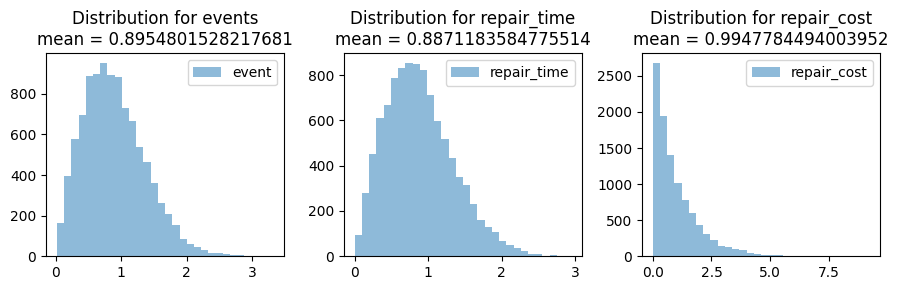

In [3]:
event = np.array([event_distribution() for _ in range(10000)])
repair_time = np.array([repair_time_distribution() for _ in range(10000)])
repair_cost = np.array([repair_cost_distribution() for _ in range(10000)])

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs = axs.flatten()

axs[0].hist(event, bins=30, alpha=0.5, label='event')
axs[0].set_title(f'Distribution for events\nmean = {event.mean()}')
axs[0].legend()

axs[1].hist(repair_time, bins=30, alpha=0.5, label='repair_time')
axs[1].set_title(f'Distribution for repair_time\nmean = {repair_time.mean()}')
axs[1].legend()

axs[2].hist(repair_cost, bins=30, alpha=0.5, label='repair_cost')
axs[2].set_title(f'Distribution for repair_cost\nmean = {repair_cost.mean()}')
axs[2].legend()

for i in range(10, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [4]:
def stop_criteria(machines,
                    spares,
                    founds,
                    buy_cost,
                    delivery_wait_time,
                    profit_function,
                    decition_function,
                    event_distribution,
                    repair_time_distribution,
                    repair_cost_distribution,
                    max_steps=1000000,
                    sjf=False):
    
    THRESHOLD = 15
    data = []
    times = []
    _founds = []

    while True:
        tmp = simulate(machines, spares, founds, buy_cost, delivery_wait_time, profit_function, decition_function, event_distribution, repair_time_distribution, repair_cost_distribution, max_steps, sjf)

        data.append(tmp)

        times.append(tmp['time'])
        _founds.append(tmp['founds'])

        standard_error1 = np.std(times) / np.sqrt(len(times))
        standard_error2 = np.std(_founds) / np.sqrt(len(_founds))
        
        if len(data) >= 30 and standard_error1 < THRESHOLD:
            break
    
    return pd.DataFrame(data)

## Experimentos


### 1 - Experimento original propuesto en el libro

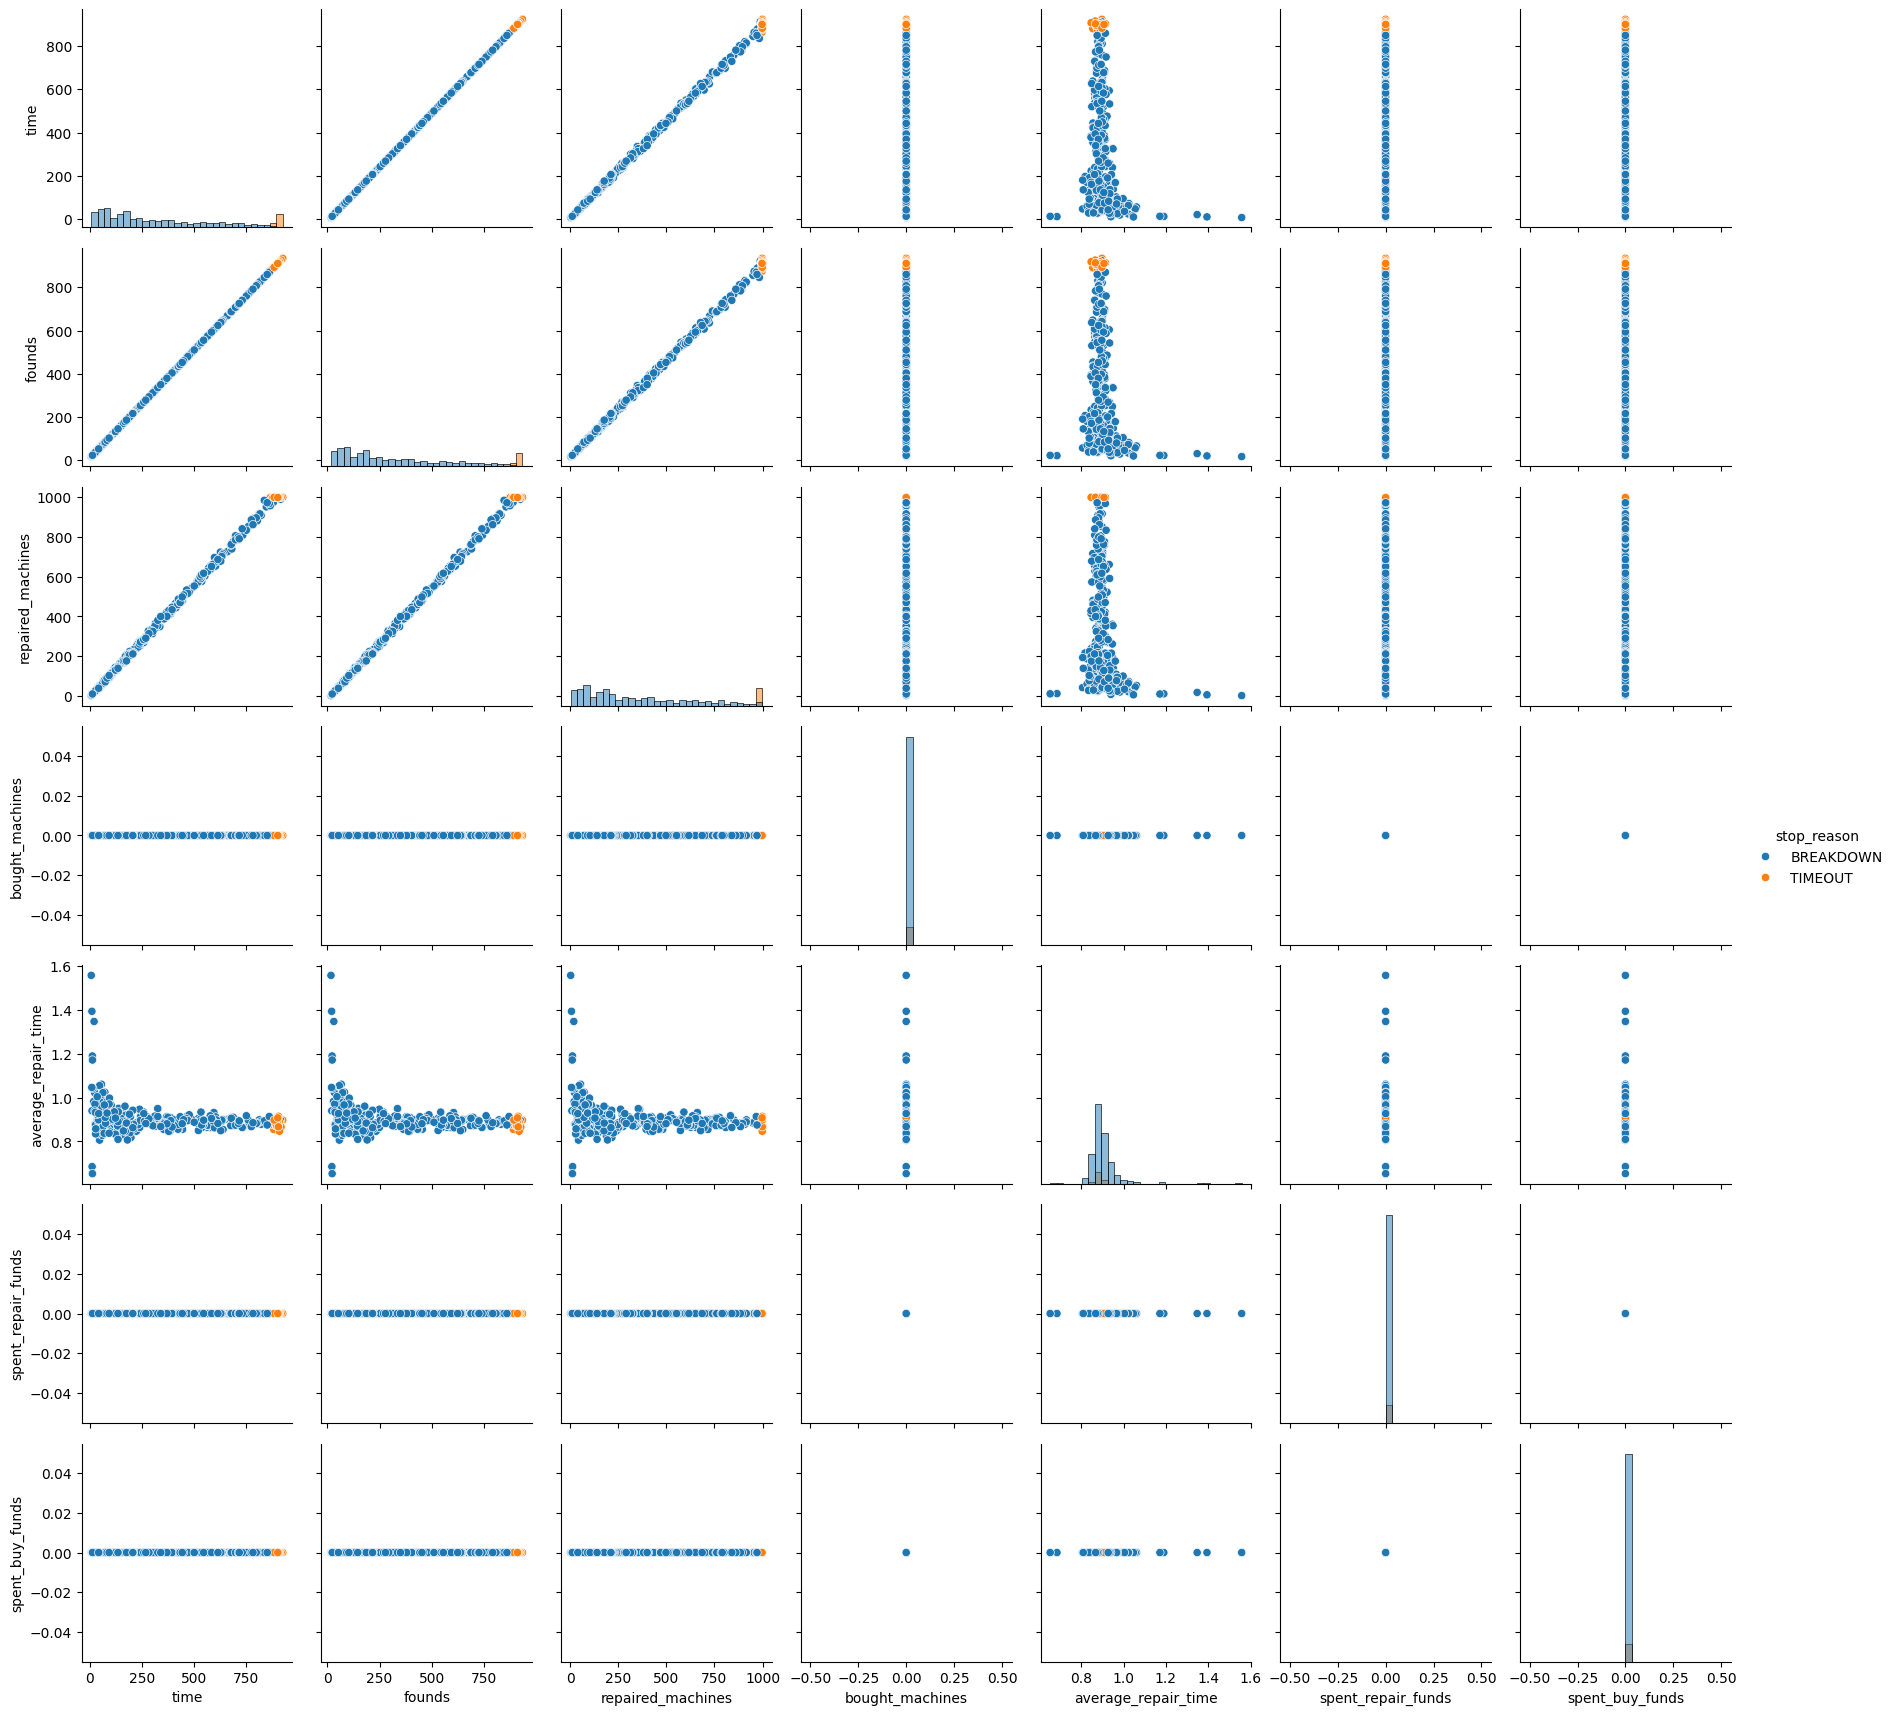

time      founds  repaired_machines  bought_machines  \
count  340.000000  340.000000         340.000000            340.0   
mean   344.041814  354.041814         381.338235              0.0   
std    276.898568  276.898568         310.576912              0.0   
min      7.323894   17.323894           3.000000              0.0   
25%    108.226991  118.226991         116.750000              0.0   
50%    260.276240  270.276240         283.000000              0.0   
75%    541.881649  551.881649         606.750000              0.0   
max    923.950656  933.950656         998.000000              0.0   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count           340.000000               340.0            340.0  
mean              0.900801                 0.0              0.0  
std               0.070412                 0.0              0.0  
min               0.652815                 0.0              0.0  
25%               0.873801                 0.0              0.0  
50%               0.888873                 0.0              0.0  
75%               0.911473                 0.0              0.0  
max               1.558094                 0.0              0.0

In [5]:
df_1_0 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        0, # costo de compra
                        0, # tiempo de entrega
                        profit_function_id, # funcion de ganancia
                        decition_function_id, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        lambda : 0, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_1_0, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_1_0.describe()

#### 1.1 - Aumentar el numero de maquinas de repuesto

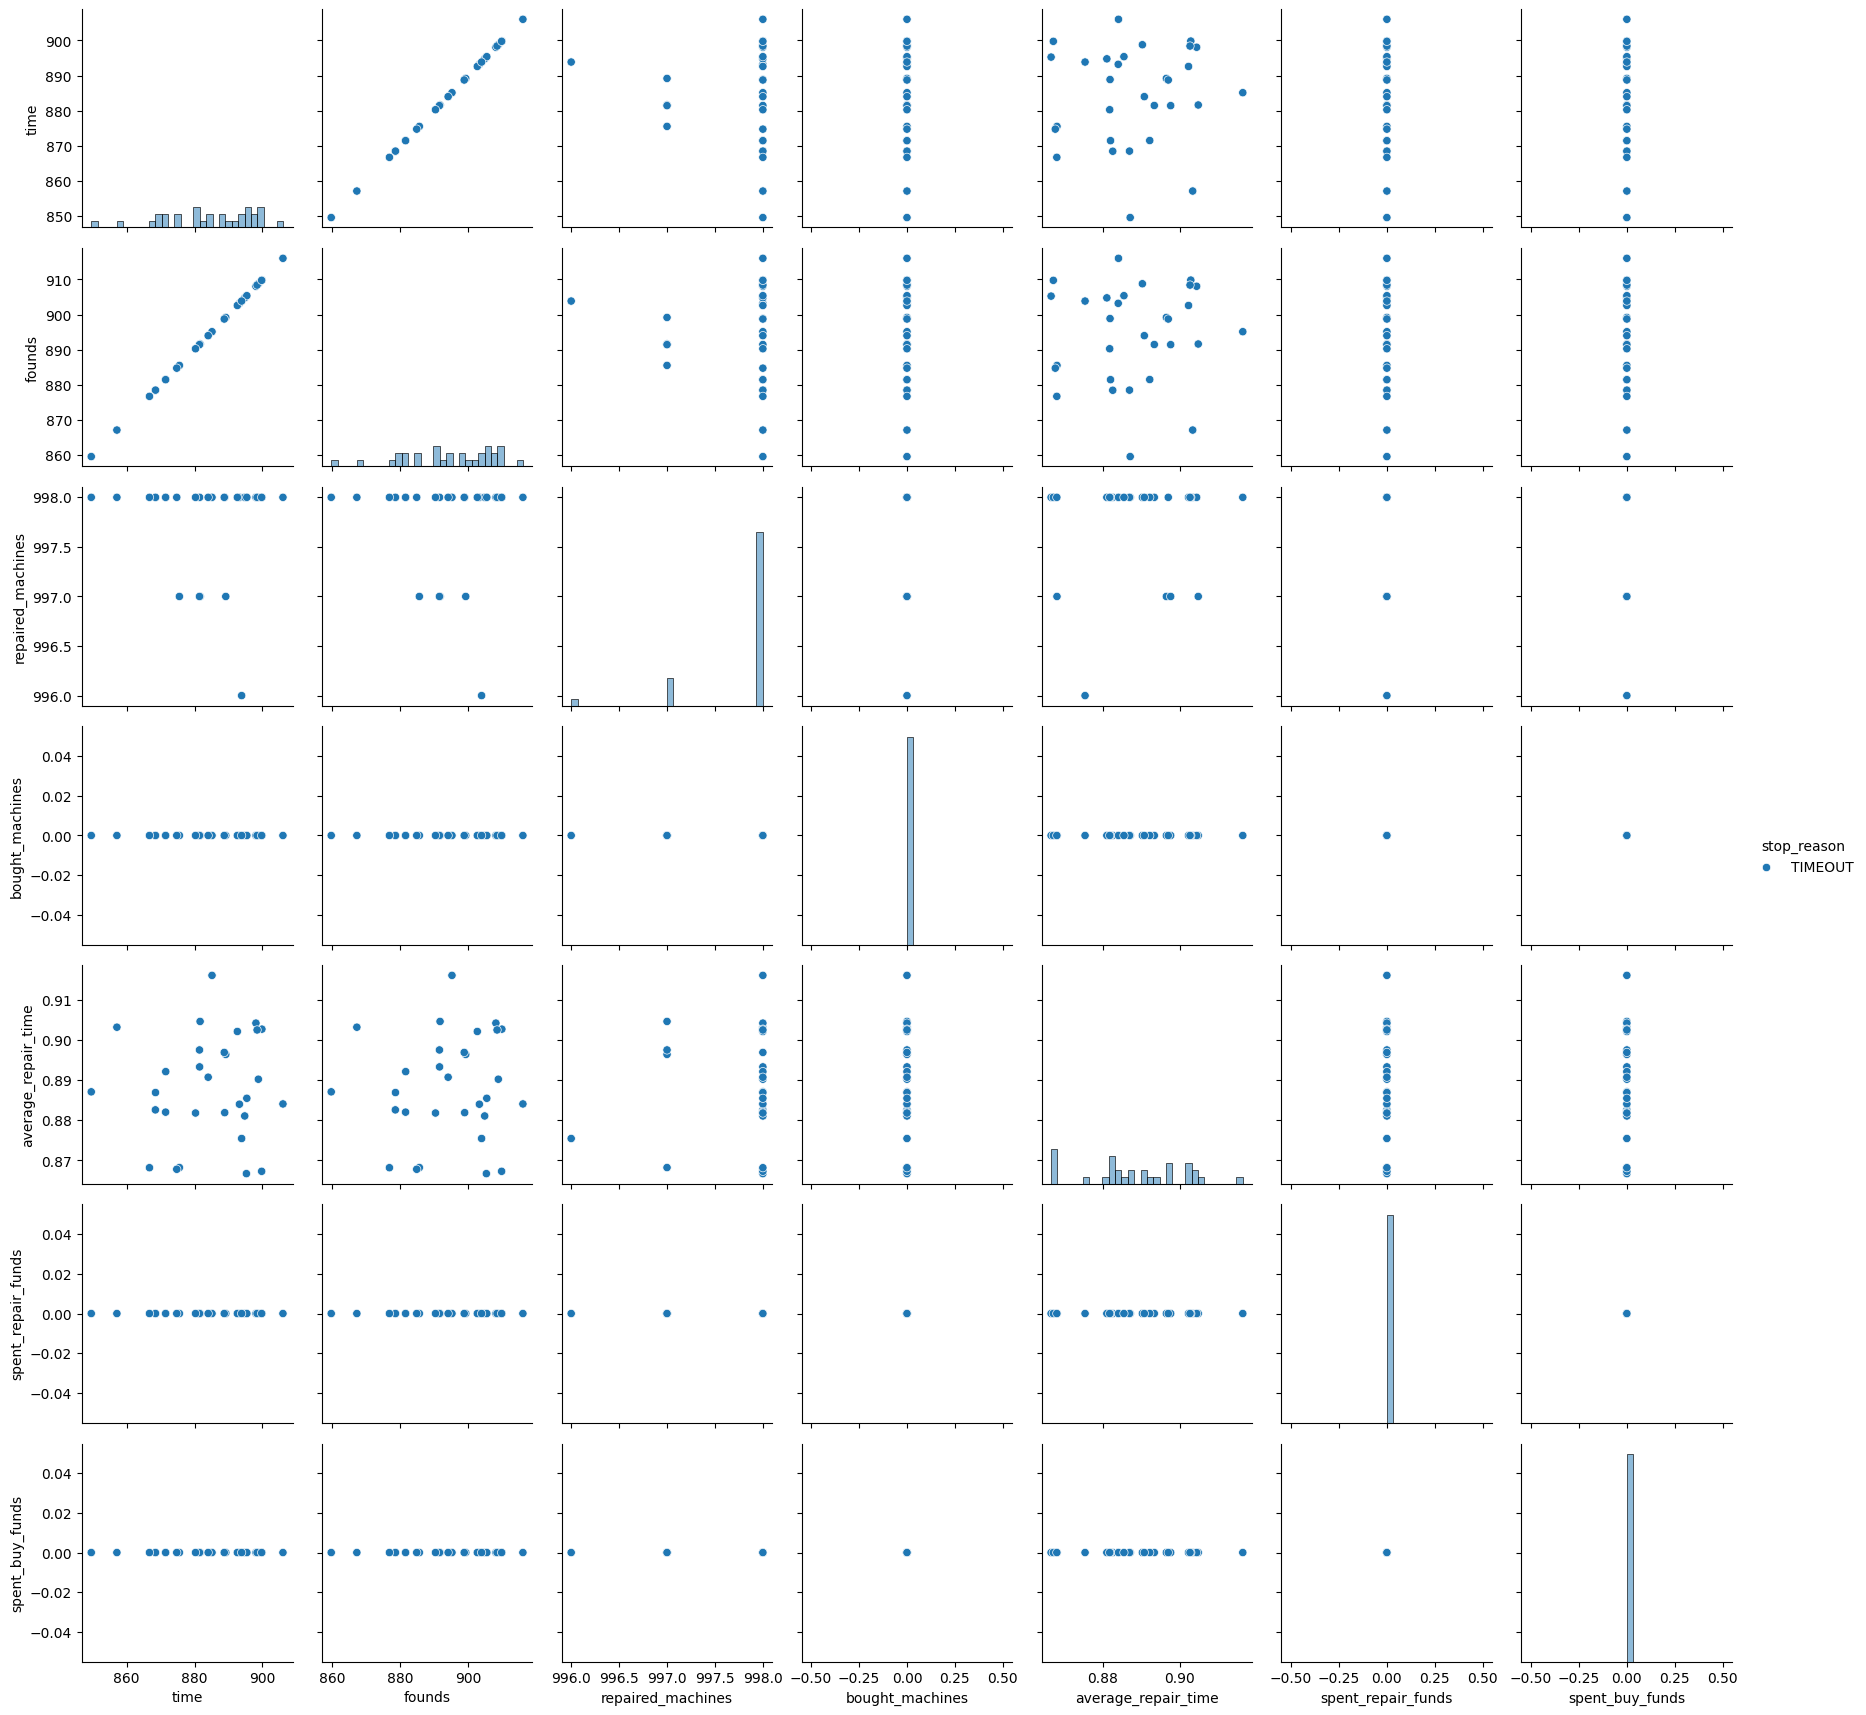

time      founds  repaired_machines  bought_machines  \
count   30.000000   30.000000          30.000000             30.0   
mean   884.358721  894.358721         997.800000              0.0   
std     13.754940   13.754940           0.484234              0.0   
min    849.622562  859.622562         996.000000              0.0   
25%    874.968693  884.968693         998.000000              0.0   
50%    886.948276  896.948276         998.000000              0.0   
75%    895.142835  905.142835         998.000000              0.0   
max    906.016651  916.016651         998.000000              0.0   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            30.000000                30.0             30.0  
mean              0.888157                 0.0              0.0  
std               0.013091                 0.0              0.0  
min               0.866697                 0.0              0.0  
25%               0.881862                 0.0              0.0  
50%               0.887042                 0.0              0.0  
75%               0.897438                 0.0              0.0  
max               0.916223                 0.0              0.0

In [6]:
df_1_1 = stop_criteria(20, # cantidad de maquinas
                        10, # cantidad de repuestos
                        10, # presupuesto inicial
                        0, # costo de compra
                        0, # tiempo de entrega
                        profit_function_id, # funcion de ganancia
                        decition_function_id, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        lambda: 0, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_1_1, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_1_1.describe()

#### 1.2 - Usar SJF para manejar los tiempos de reparacion

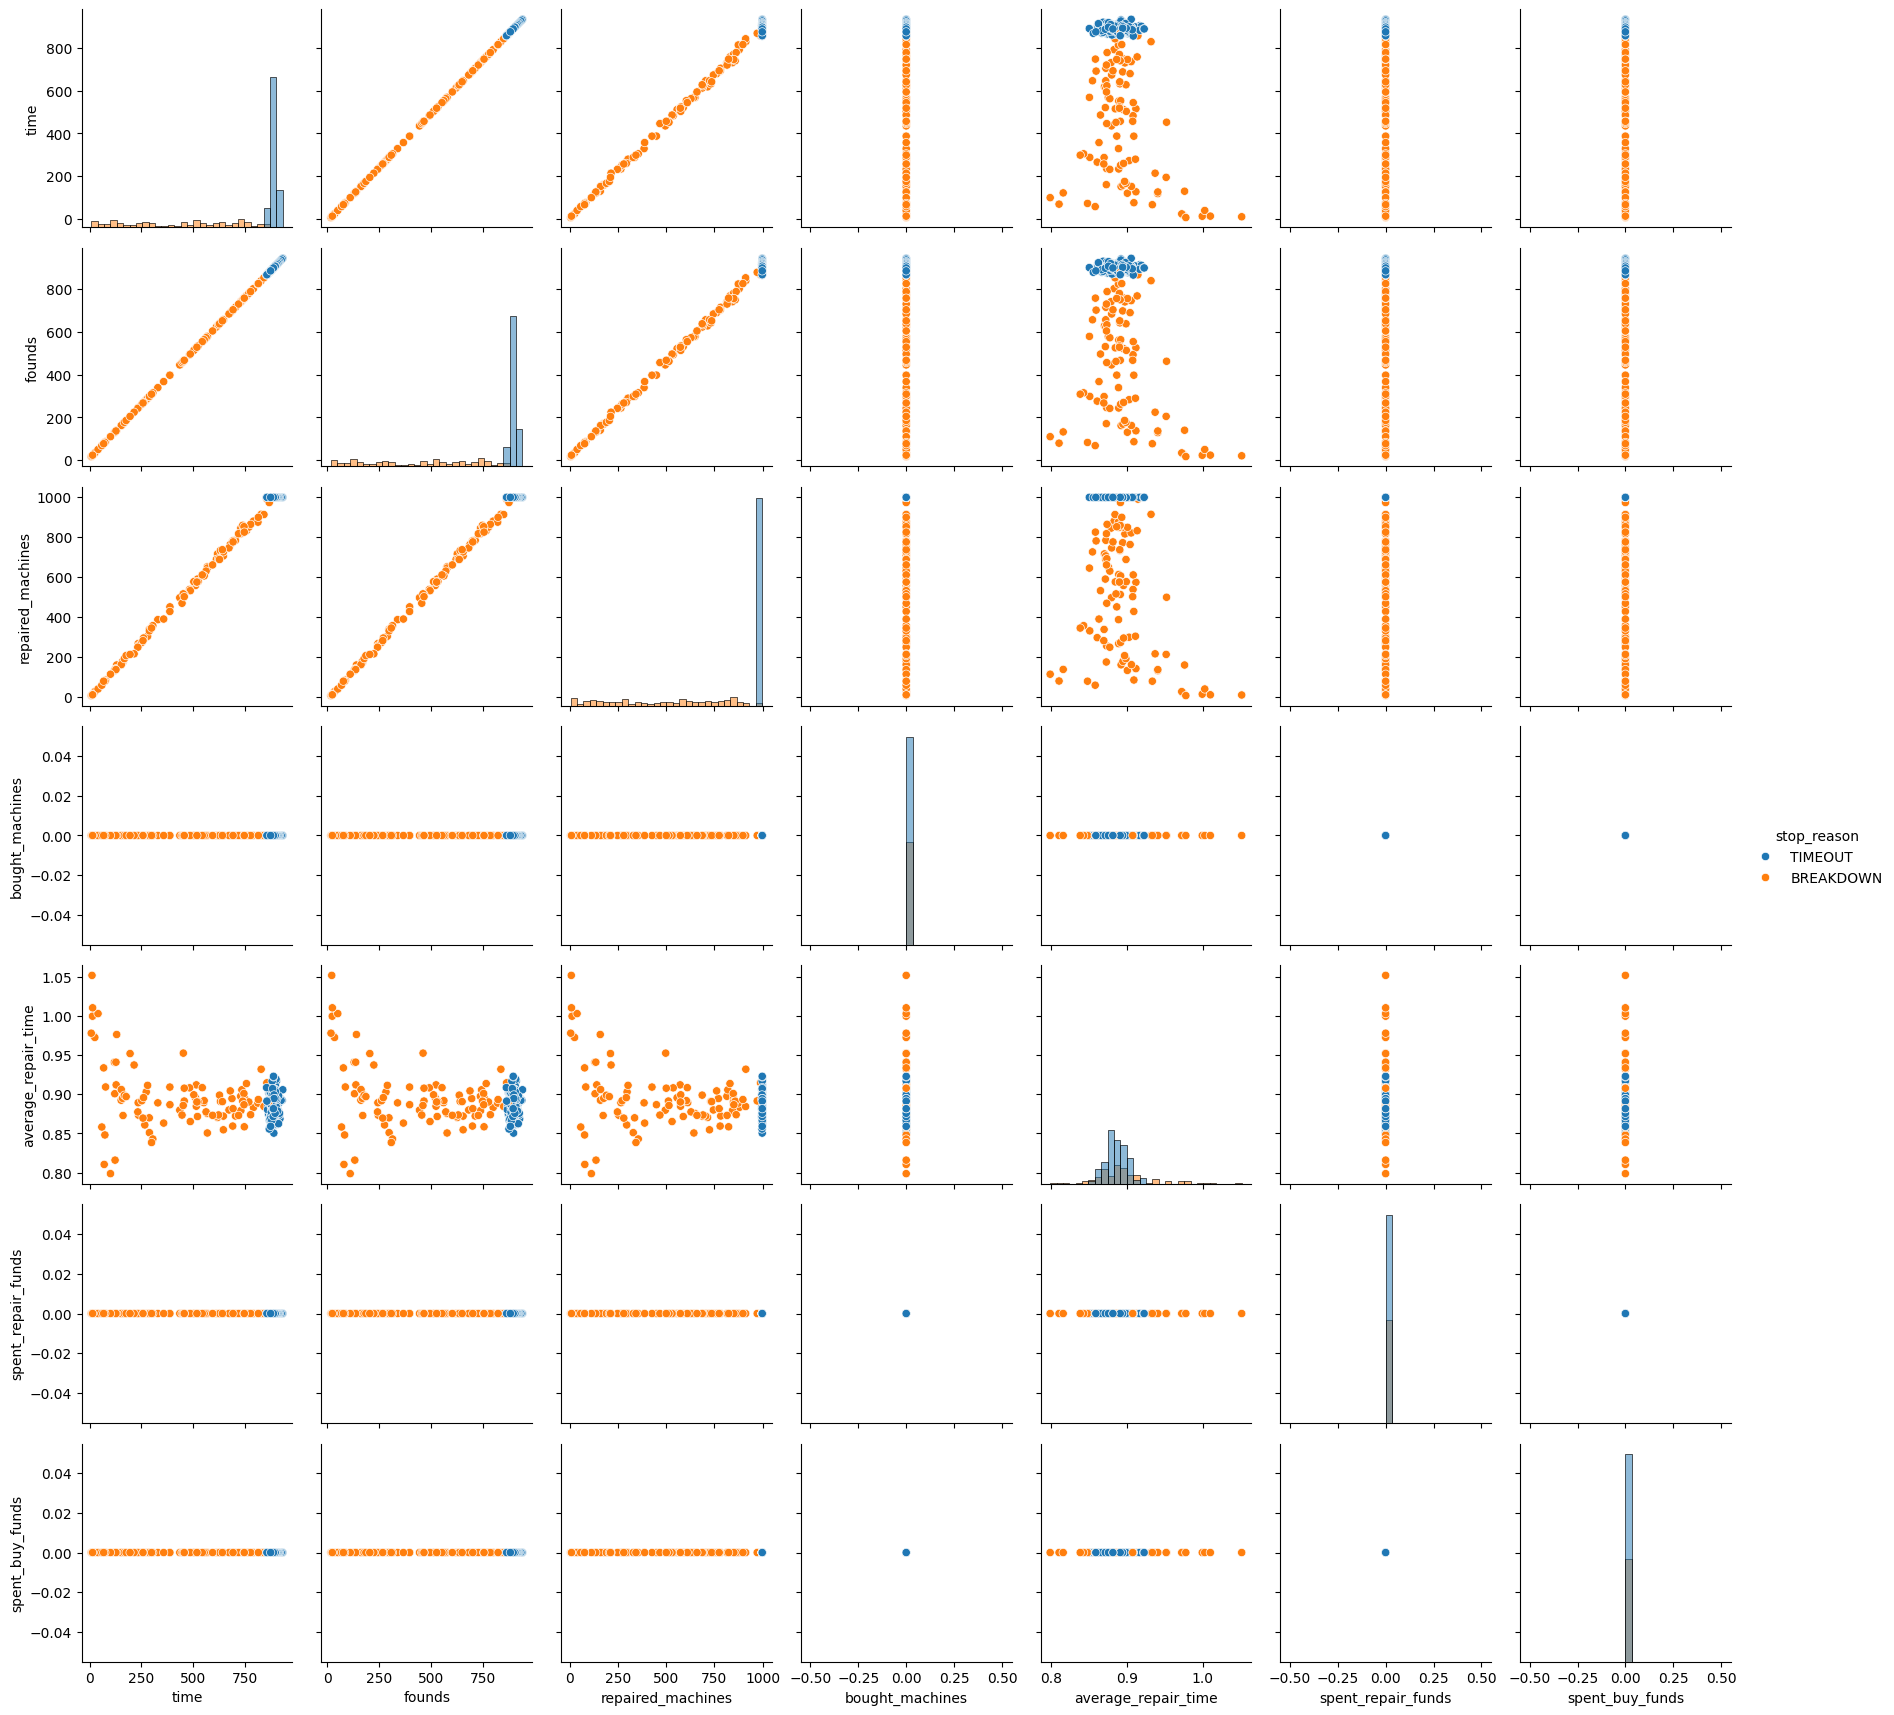

time      founds  repaired_machines  bought_machines  \
count  303.000000  303.000000         303.000000            303.0   
mean   739.195494  749.195494         828.940594              0.0   
std    260.882206  260.882206         293.685932              0.0   
min      7.429326   17.429326           6.000000              0.0   
25%    683.479128  693.479128         766.500000              0.0   
50%    879.773104  889.773104         998.000000              0.0   
75%    892.456163  902.456163         998.000000              0.0   
max    933.072032  943.072032         998.000000              0.0   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count           303.000000               303.0            303.0  
mean              0.889240                 0.0              0.0  
std               0.025788                 0.0              0.0  
min               0.798724                 0.0              0.0  
25%               0.875613                 0.0              0.0  
50%               0.887759                 0.0              0.0  
75%               0.897980                 0.0              0.0  
max               1.051675                 0.0              0.0

In [7]:
df_1_2 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        0, # costo de compra
                        0, # tiempo de entrega
                        profit_function_id, # funcion de ganancia
                        decition_function_id, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        lambda : 0, # distribucion de los costos de reparacion
                        1000, sjf=True) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_1_2, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_1_2.describe()

#### 1.3 - Usar una distribucion para el costo de reparacion

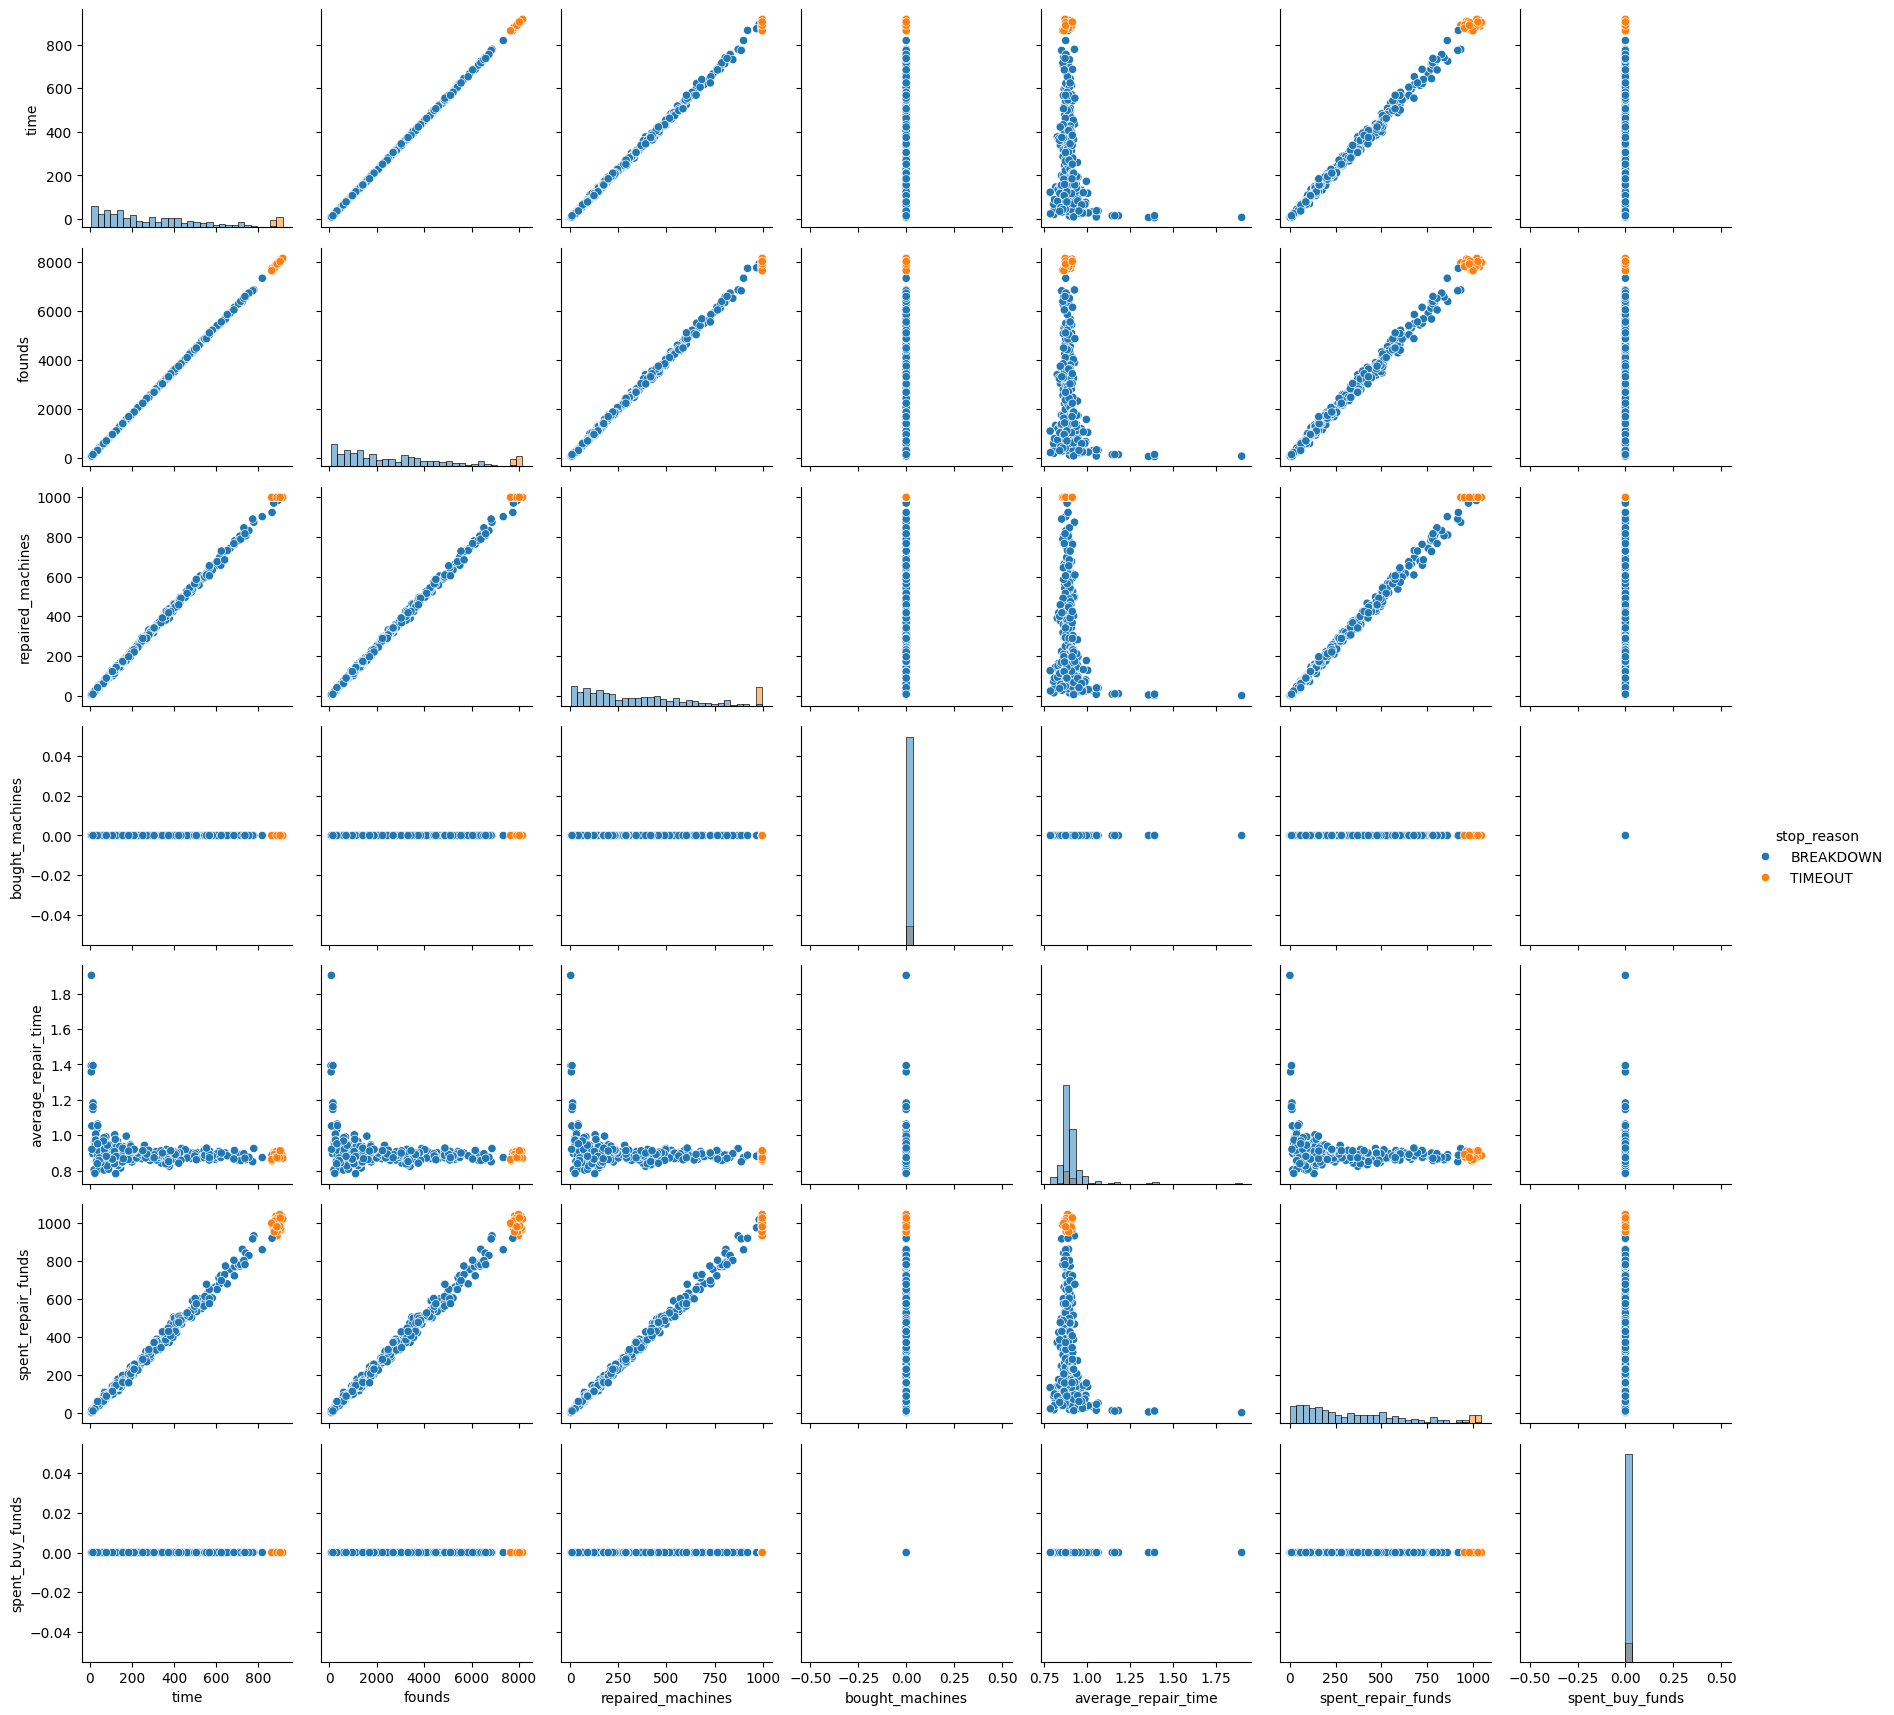

time       founds  repaired_machines  bought_machines  \
count  314.000000   314.000000         314.000000            314.0   
mean   328.862834  2932.937895         364.987261              0.0   
std    265.771289  2359.395870         298.389083              0.0   
min      6.969238    70.652668           2.000000              0.0   
25%    108.559729   981.954947         123.250000              0.0   
50%    265.884446  2364.167222         291.500000              0.0   
75%    482.637156  4319.437588         542.500000              0.0   
max    915.737216  8145.794461         998.000000              0.0   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count           314.000000          314.000000            314.0  
mean              0.903052          365.690443              0.0  
std               0.087778          299.188010              0.0  
min               0.784090            0.902728              0.0  
25%               0.872614          117.893191              0.0  
50%               0.888774          285.310907              0.0  
75%               0.912425          533.046975              0.0  
max               1.902767         1045.863485              0.0

In [8]:
df_1_3 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        0, # costo de compra
                        0, # tiempo de entrega
                        profit_function_ln, # funcion de ganancia
                        decition_function_id, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_1_3, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_1_3.describe()

### 2 - Usar una funcion de decision lineal

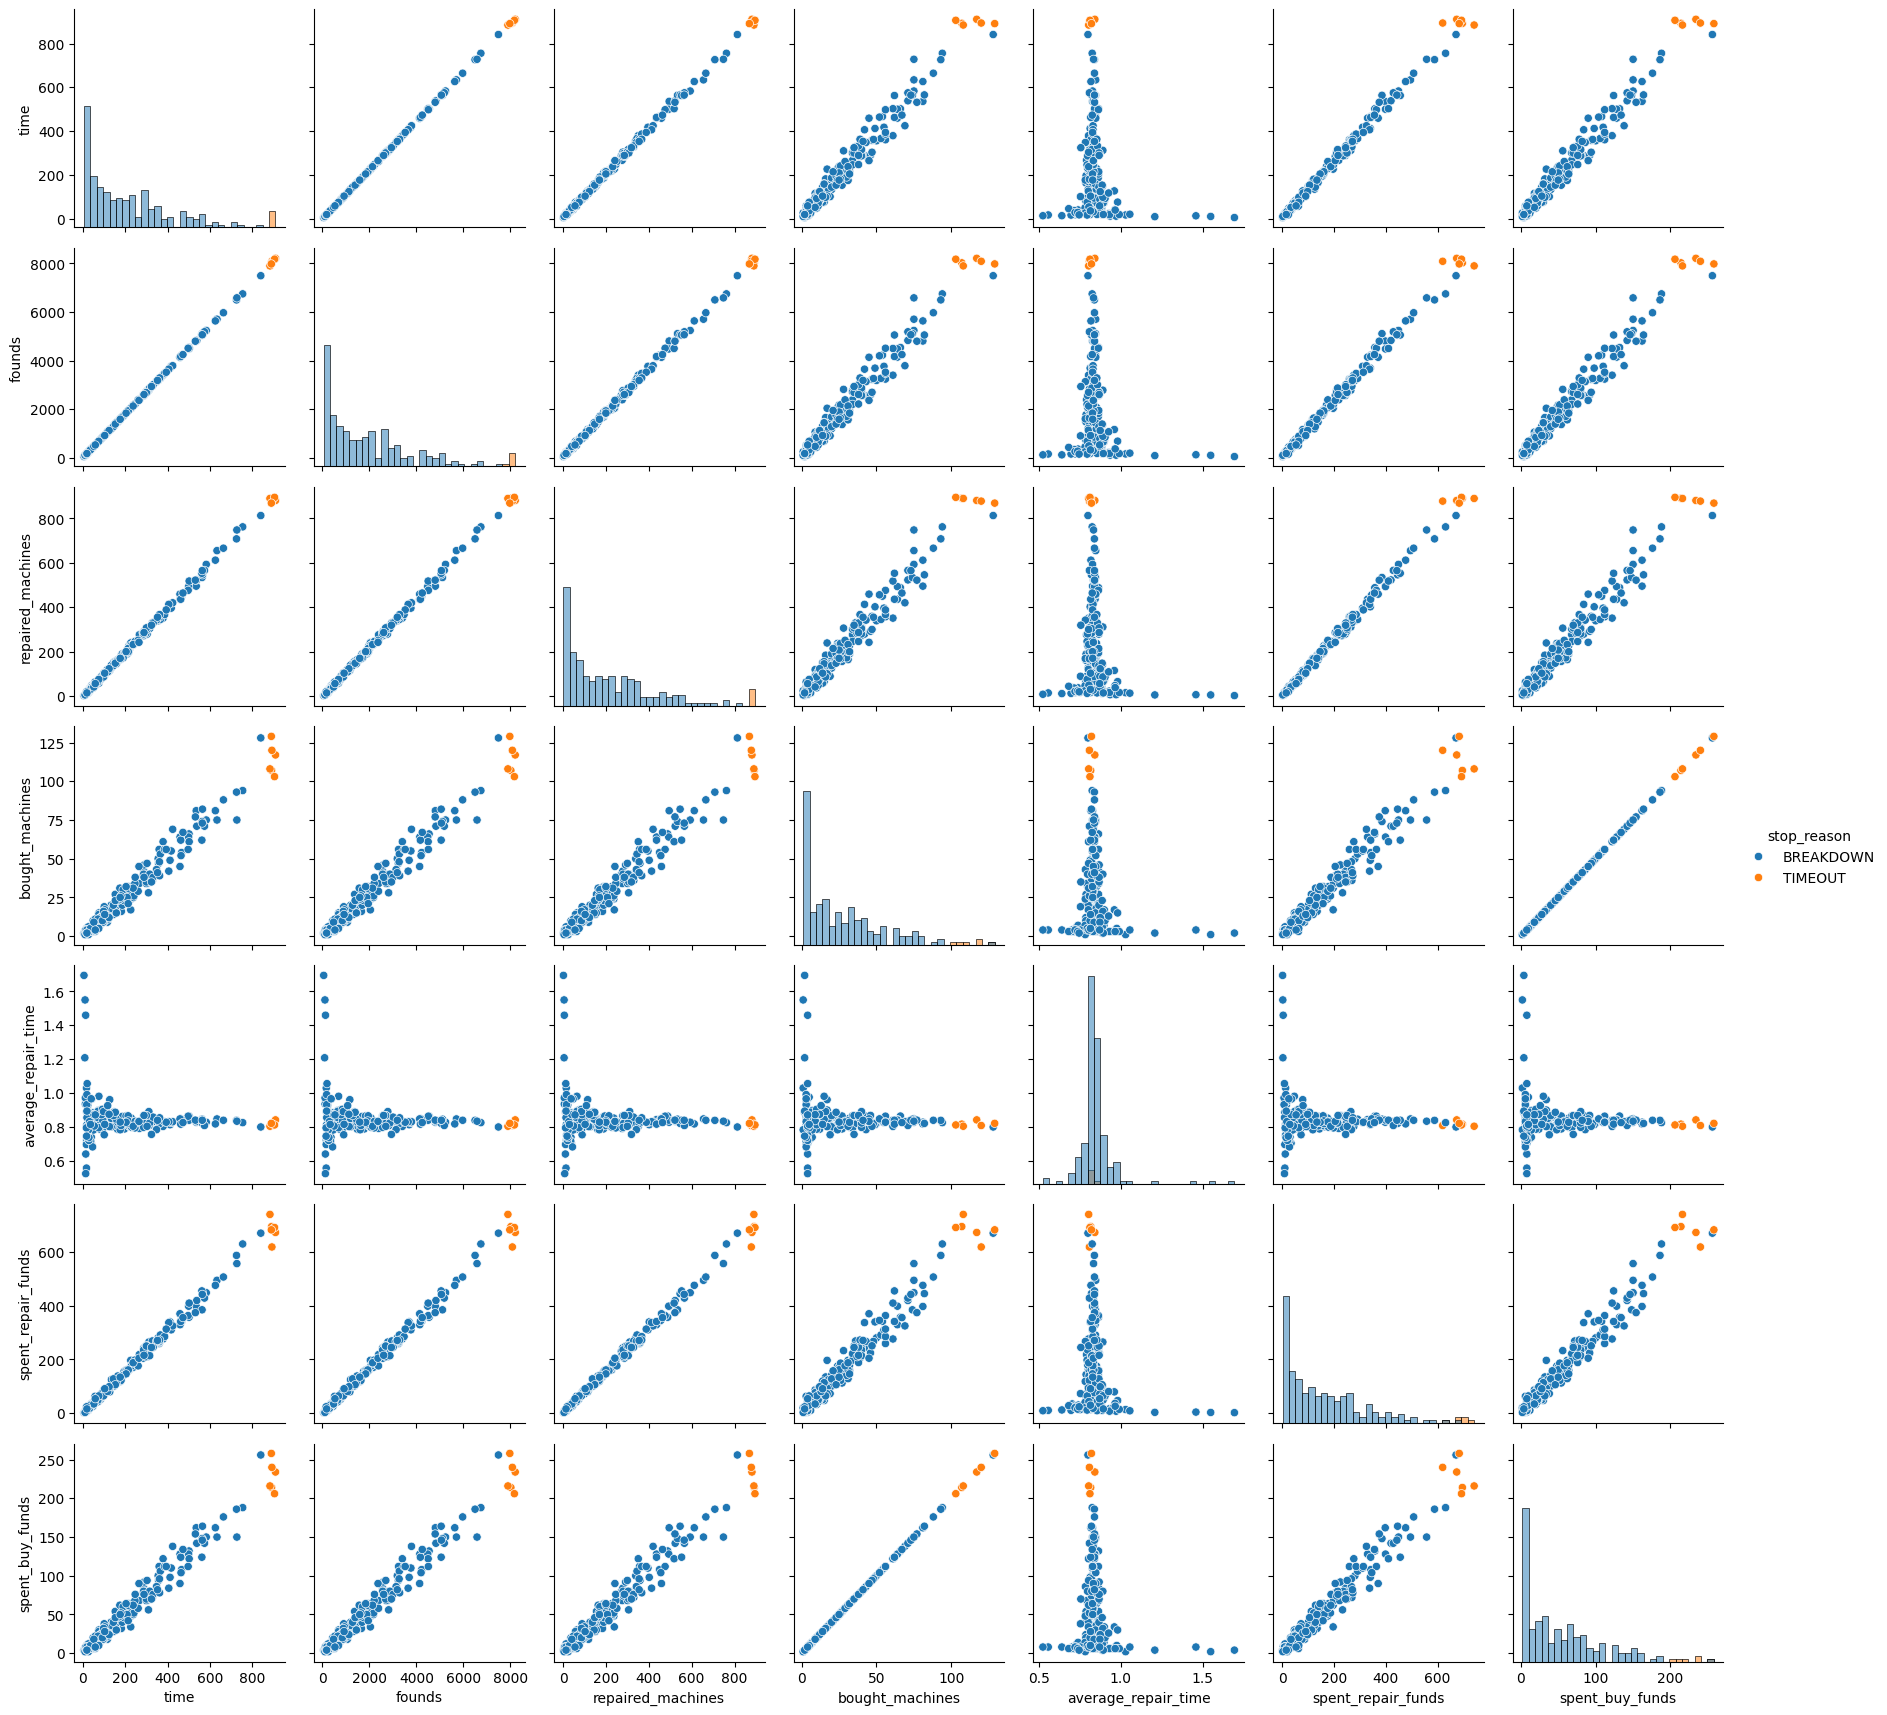

time       founds  repaired_machines  bought_machines  \
count  207.000000   207.000000         207.000000       207.000000   
mean   221.421546  1998.615159         216.019324        28.526570   
std    216.027983  1938.092445         214.243985        28.098786   
min      4.856732    53.012087           2.000000         1.000000   
25%     42.316176   388.131124          38.000000         5.000000   
50%    159.378961  1461.530703         156.000000        20.000000   
75%    312.846429  2826.695692         307.000000        40.000000   
max    910.651545  8209.101828         895.000000       129.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count           207.000000          207.000000       207.000000  
mean              0.846809          168.788710        57.053140  
std               0.111814          167.374439        56.197572  
min               0.524824            1.555233         2.000000  
25%               0.808714           29.762631        10.000000  
50%               0.831385          119.256343        40.000000  
75%               0.864754          247.043279        80.000000  
max               1.694954          740.711495       258.000000

In [9]:
df_2_0 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_ln, # funcion de ganancia
                        decition_function_ln, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_2_0, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_2_0.describe()

#### 2.1 - Usar funcion de ganancia $sen(t) + 1$

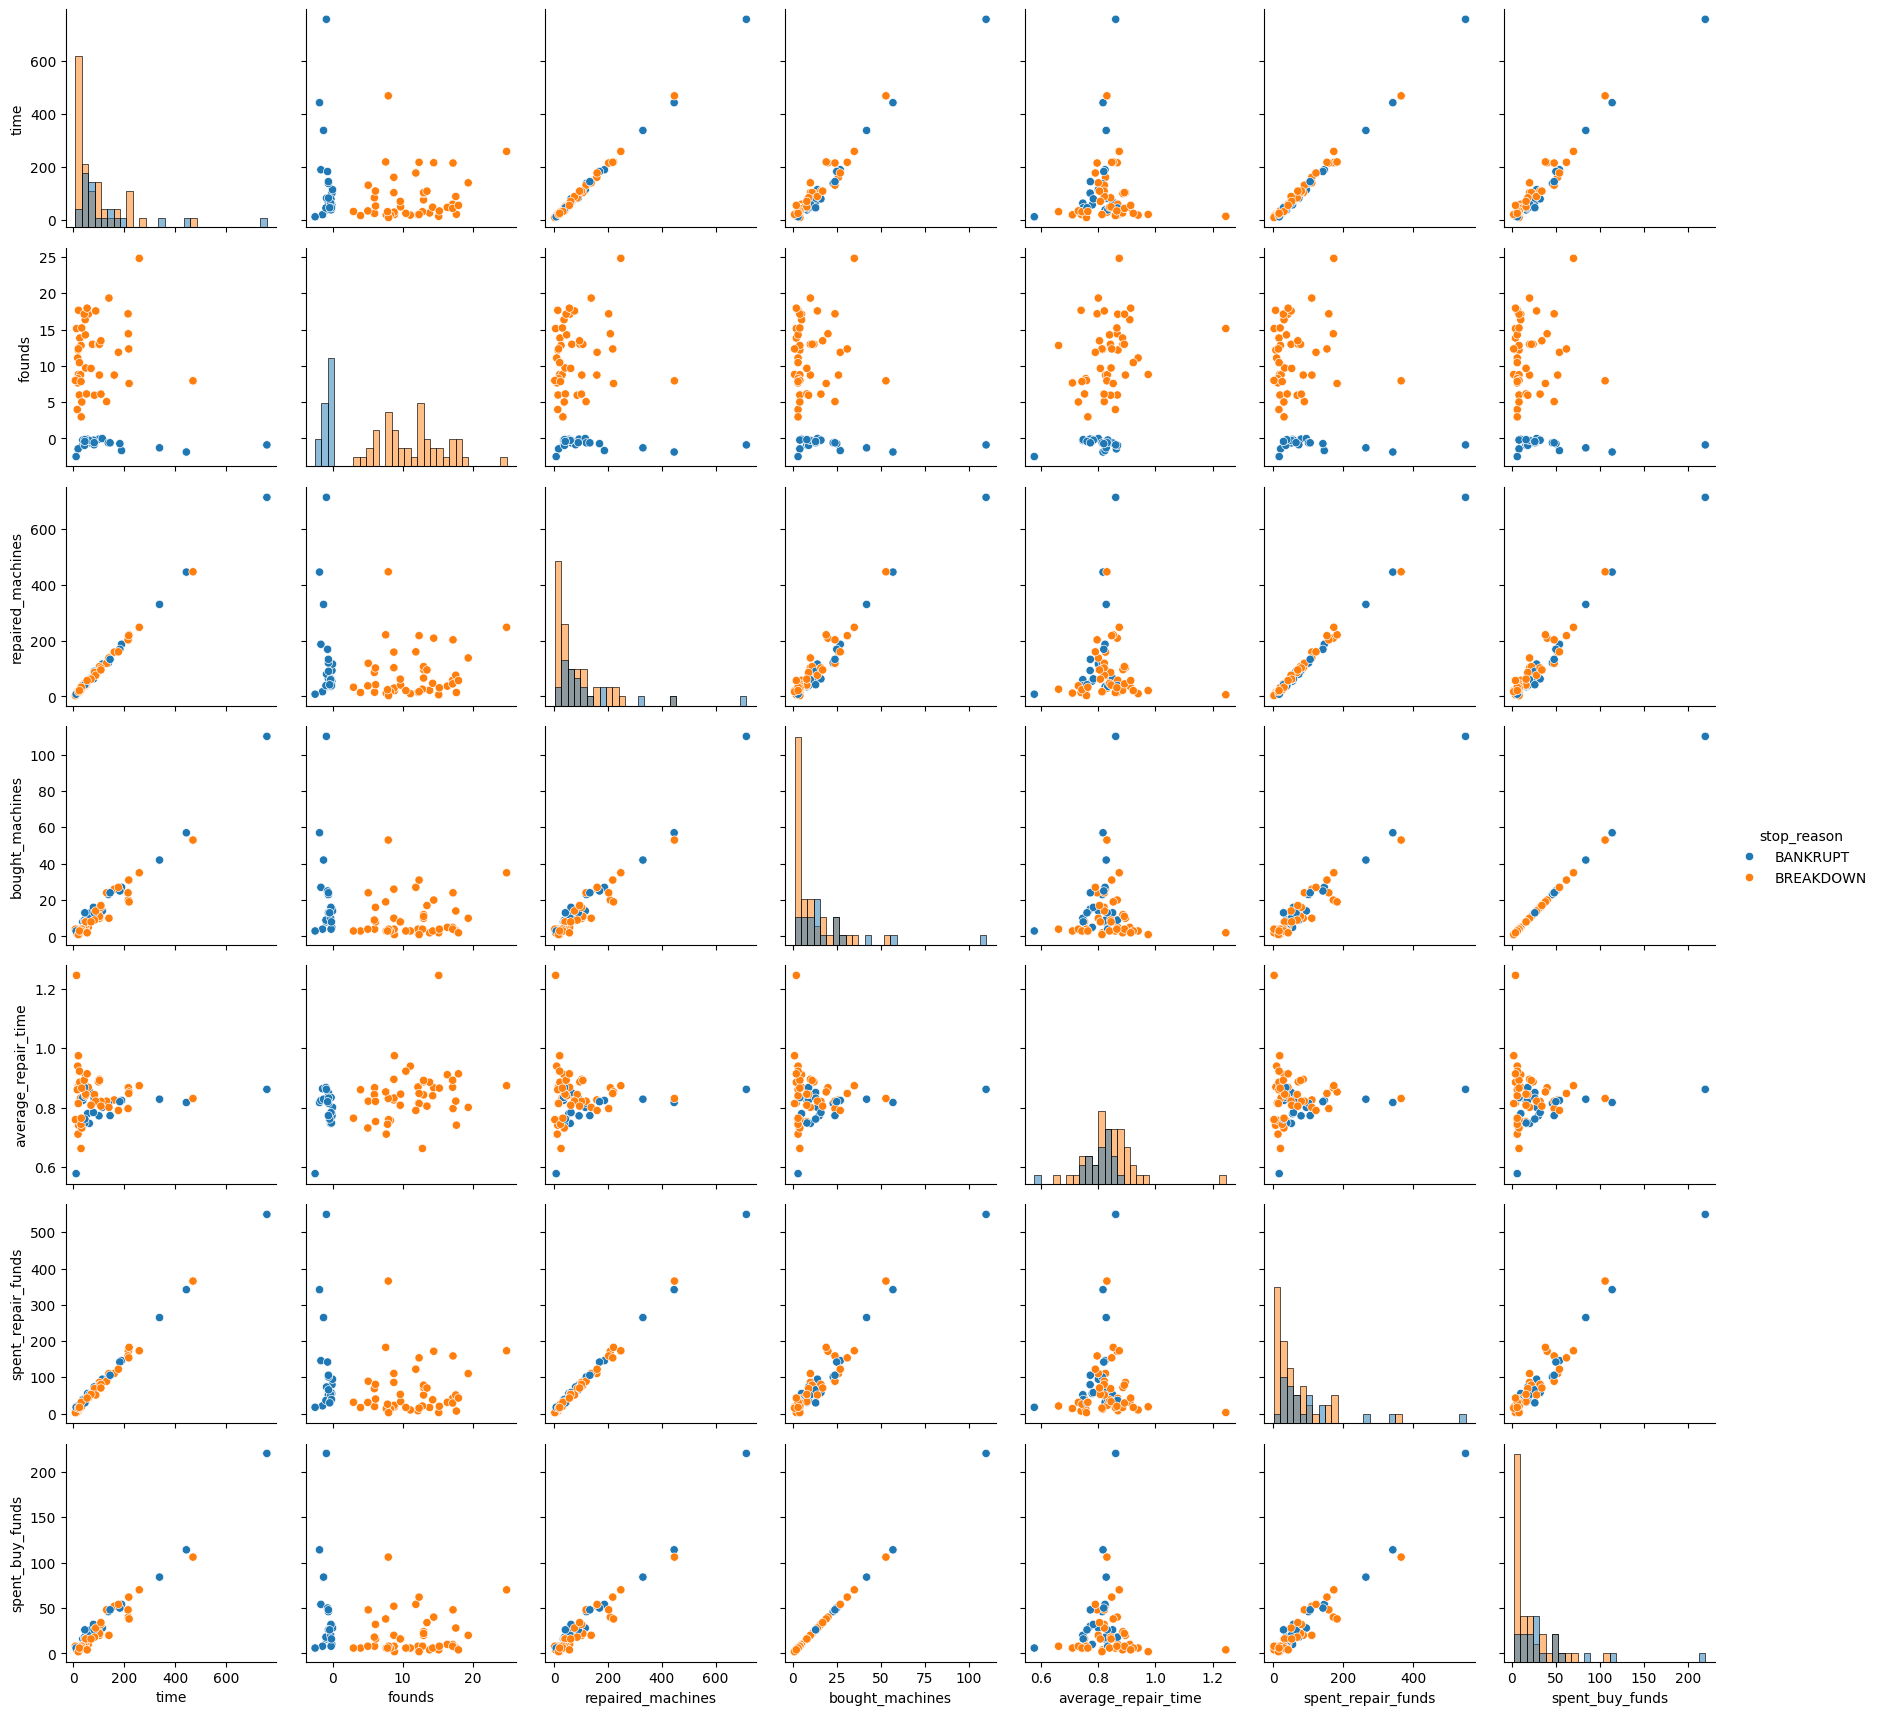

time     founds  repaired_machines  bought_machines  \
count   68.000000  68.000000          68.000000        68.000000   
mean   101.765875   7.520689          96.529412        13.573529   
std    124.081322   6.947214         119.830910        16.774462   
min      8.268184  -2.499034           3.000000         1.000000   
25%     30.024338  -0.224260          25.500000         4.000000   
50%     57.580619   7.960570          57.500000         8.500000   
75%    118.010931  12.973990         116.750000        16.250000   
max    758.675874  24.814526         714.000000       110.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            68.000000           68.000000        68.000000  
mean              0.828058           76.999902        27.147059  
std               0.081911           92.703269        33.548924  
min               0.577384            2.688112         2.000000  
25%               0.788540           21.417908         8.000000  
50%               0.825662           47.162937        17.000000  
75%               0.865819           90.727293        32.500000  
max               1.245380          549.584414       220.000000

In [10]:
df_2_1 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_ln, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_2_1, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_2_1.describe()

### 3 - Usando la funcion de ganancia sn_lg probar las funciones de decision cuadraticas

#### 3.0 - Funcion de decision lineal

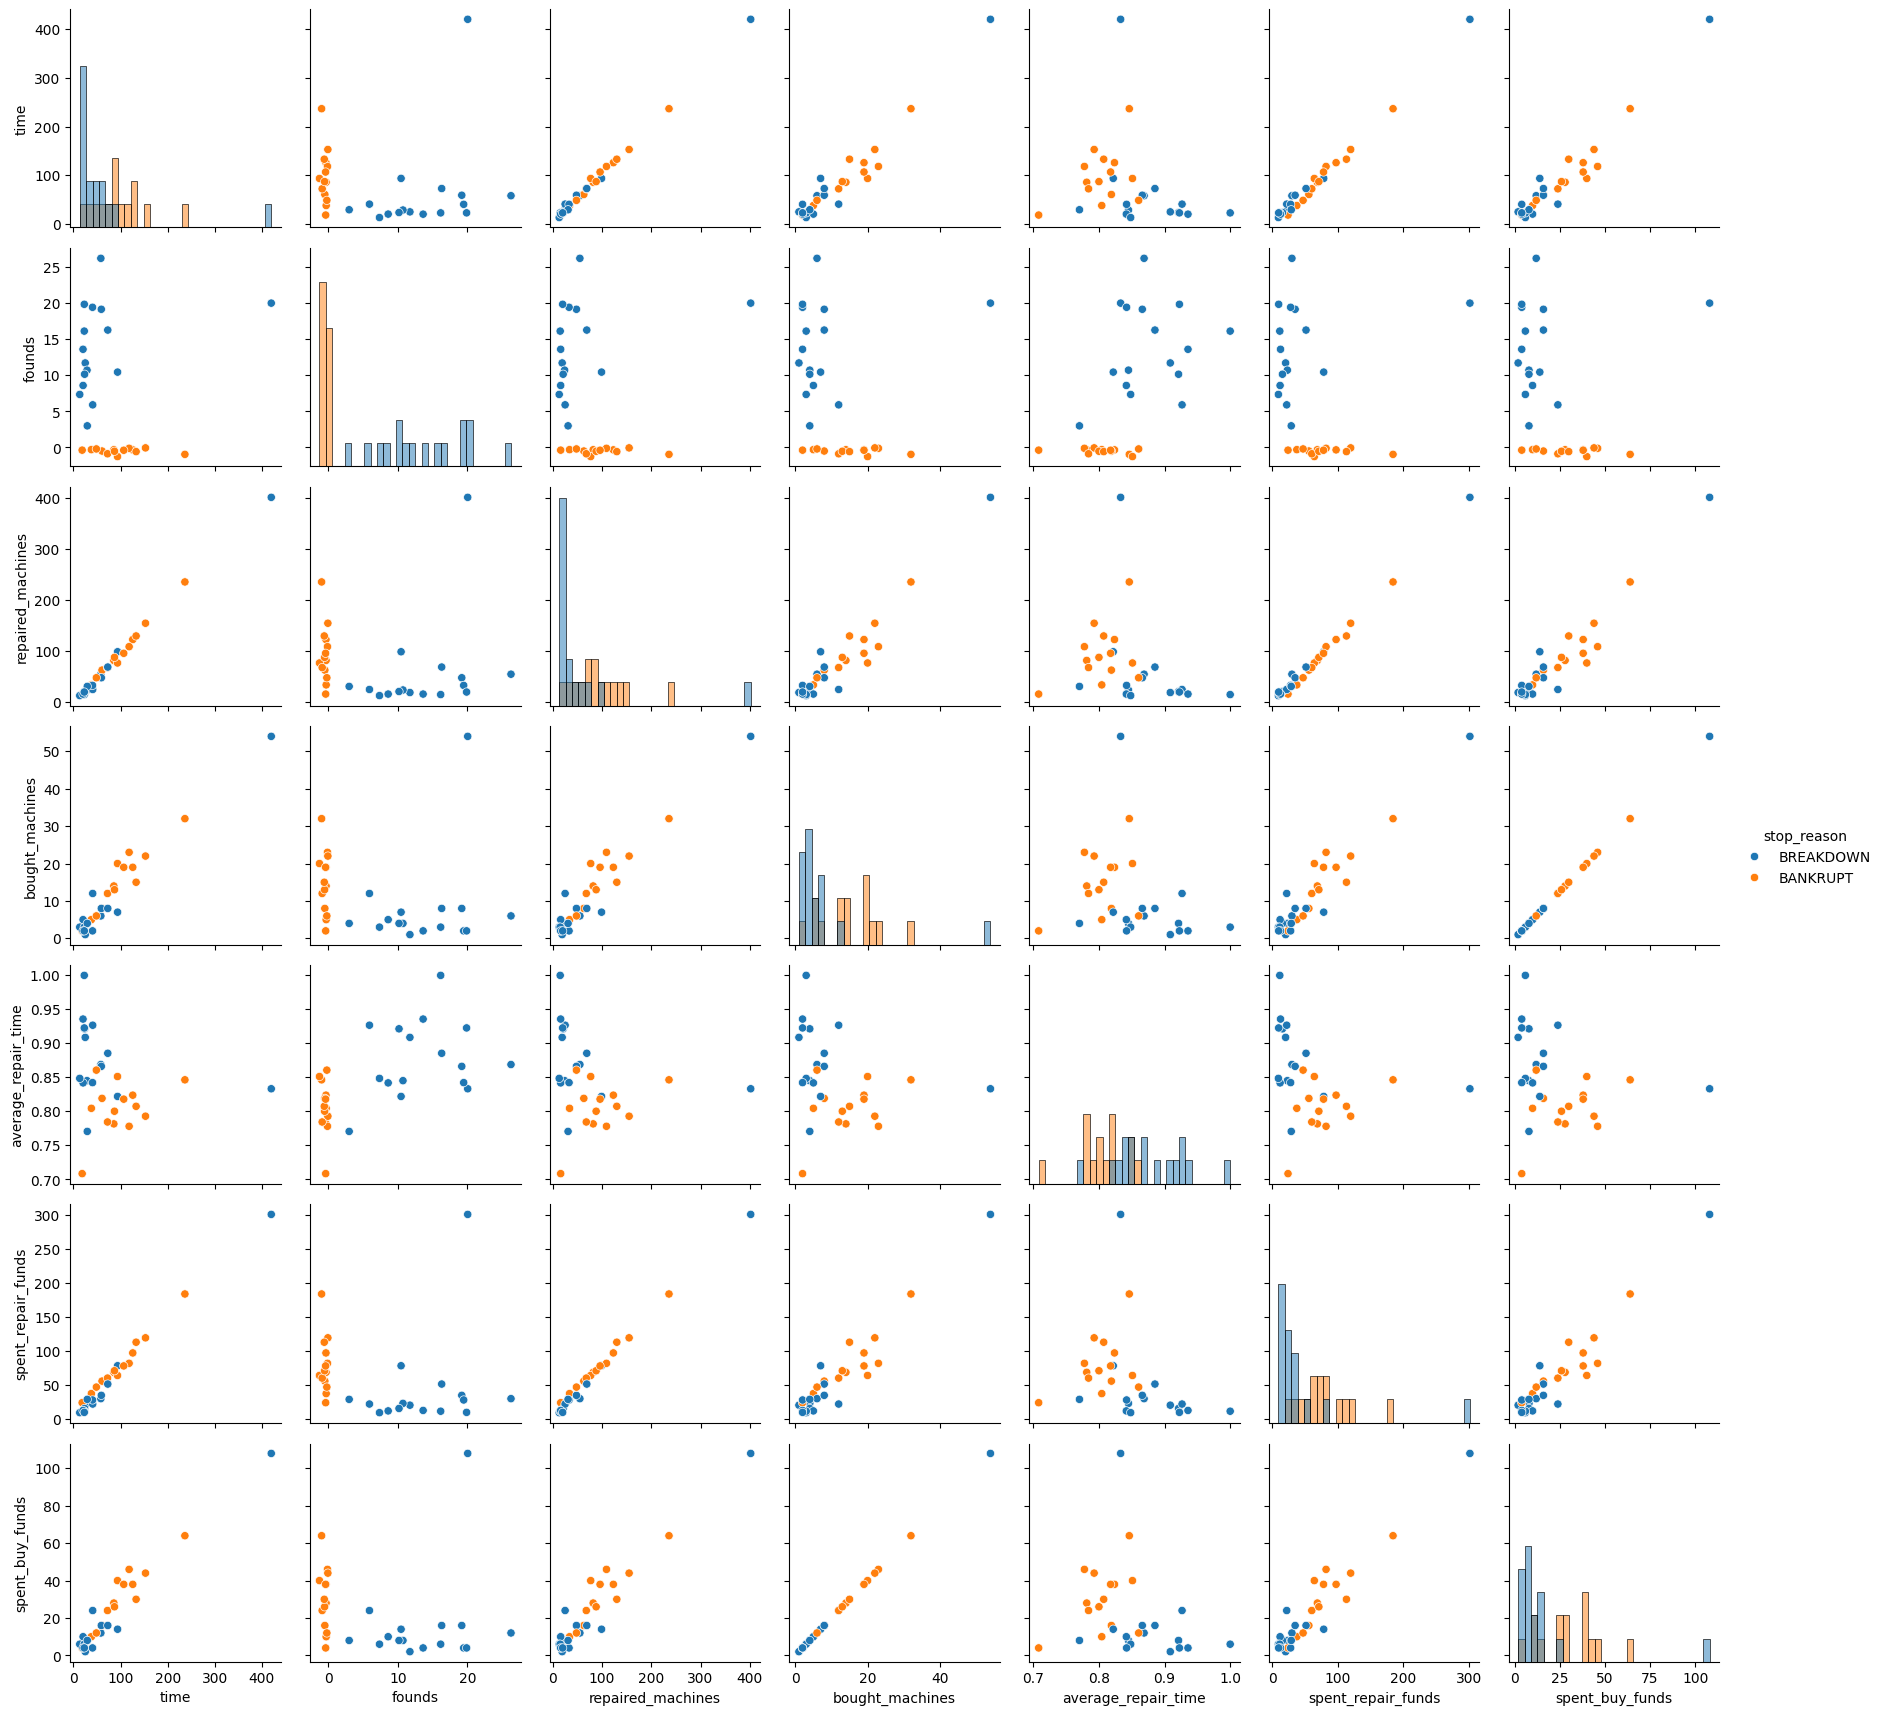

time     founds  repaired_machines  bought_machines  \
count   30.000000  30.000000          30.000000        30.000000   
mean    78.957876   7.062955          74.366667        11.166667   
std     81.658822   8.487285          80.192649        11.231370   
min     13.319869  -1.272194          13.000000         1.000000   
25%     25.917821  -0.370026          21.750000         4.000000   
50%     58.608303   4.452450          51.500000         7.500000   
75%     93.605276  13.149154          94.000000        14.750000   
max    419.901478  26.253131         402.000000        54.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            30.000000           30.000000        30.000000  
mean              0.843848           59.639796        22.333333  
std               0.059992           60.698609        22.462741  
min               0.708473            9.236683         2.000000  
25%               0.805225           22.173402         8.000000  
50%               0.842062           42.113588        15.000000  
75%               0.868187           76.318994        29.500000  
max               0.999889          301.389894       108.000000

In [11]:
df_3_0 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_ln, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_0, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_0.describe()

#### 3.1 - Funcion de decision random (uniforme ~ {0, 1})

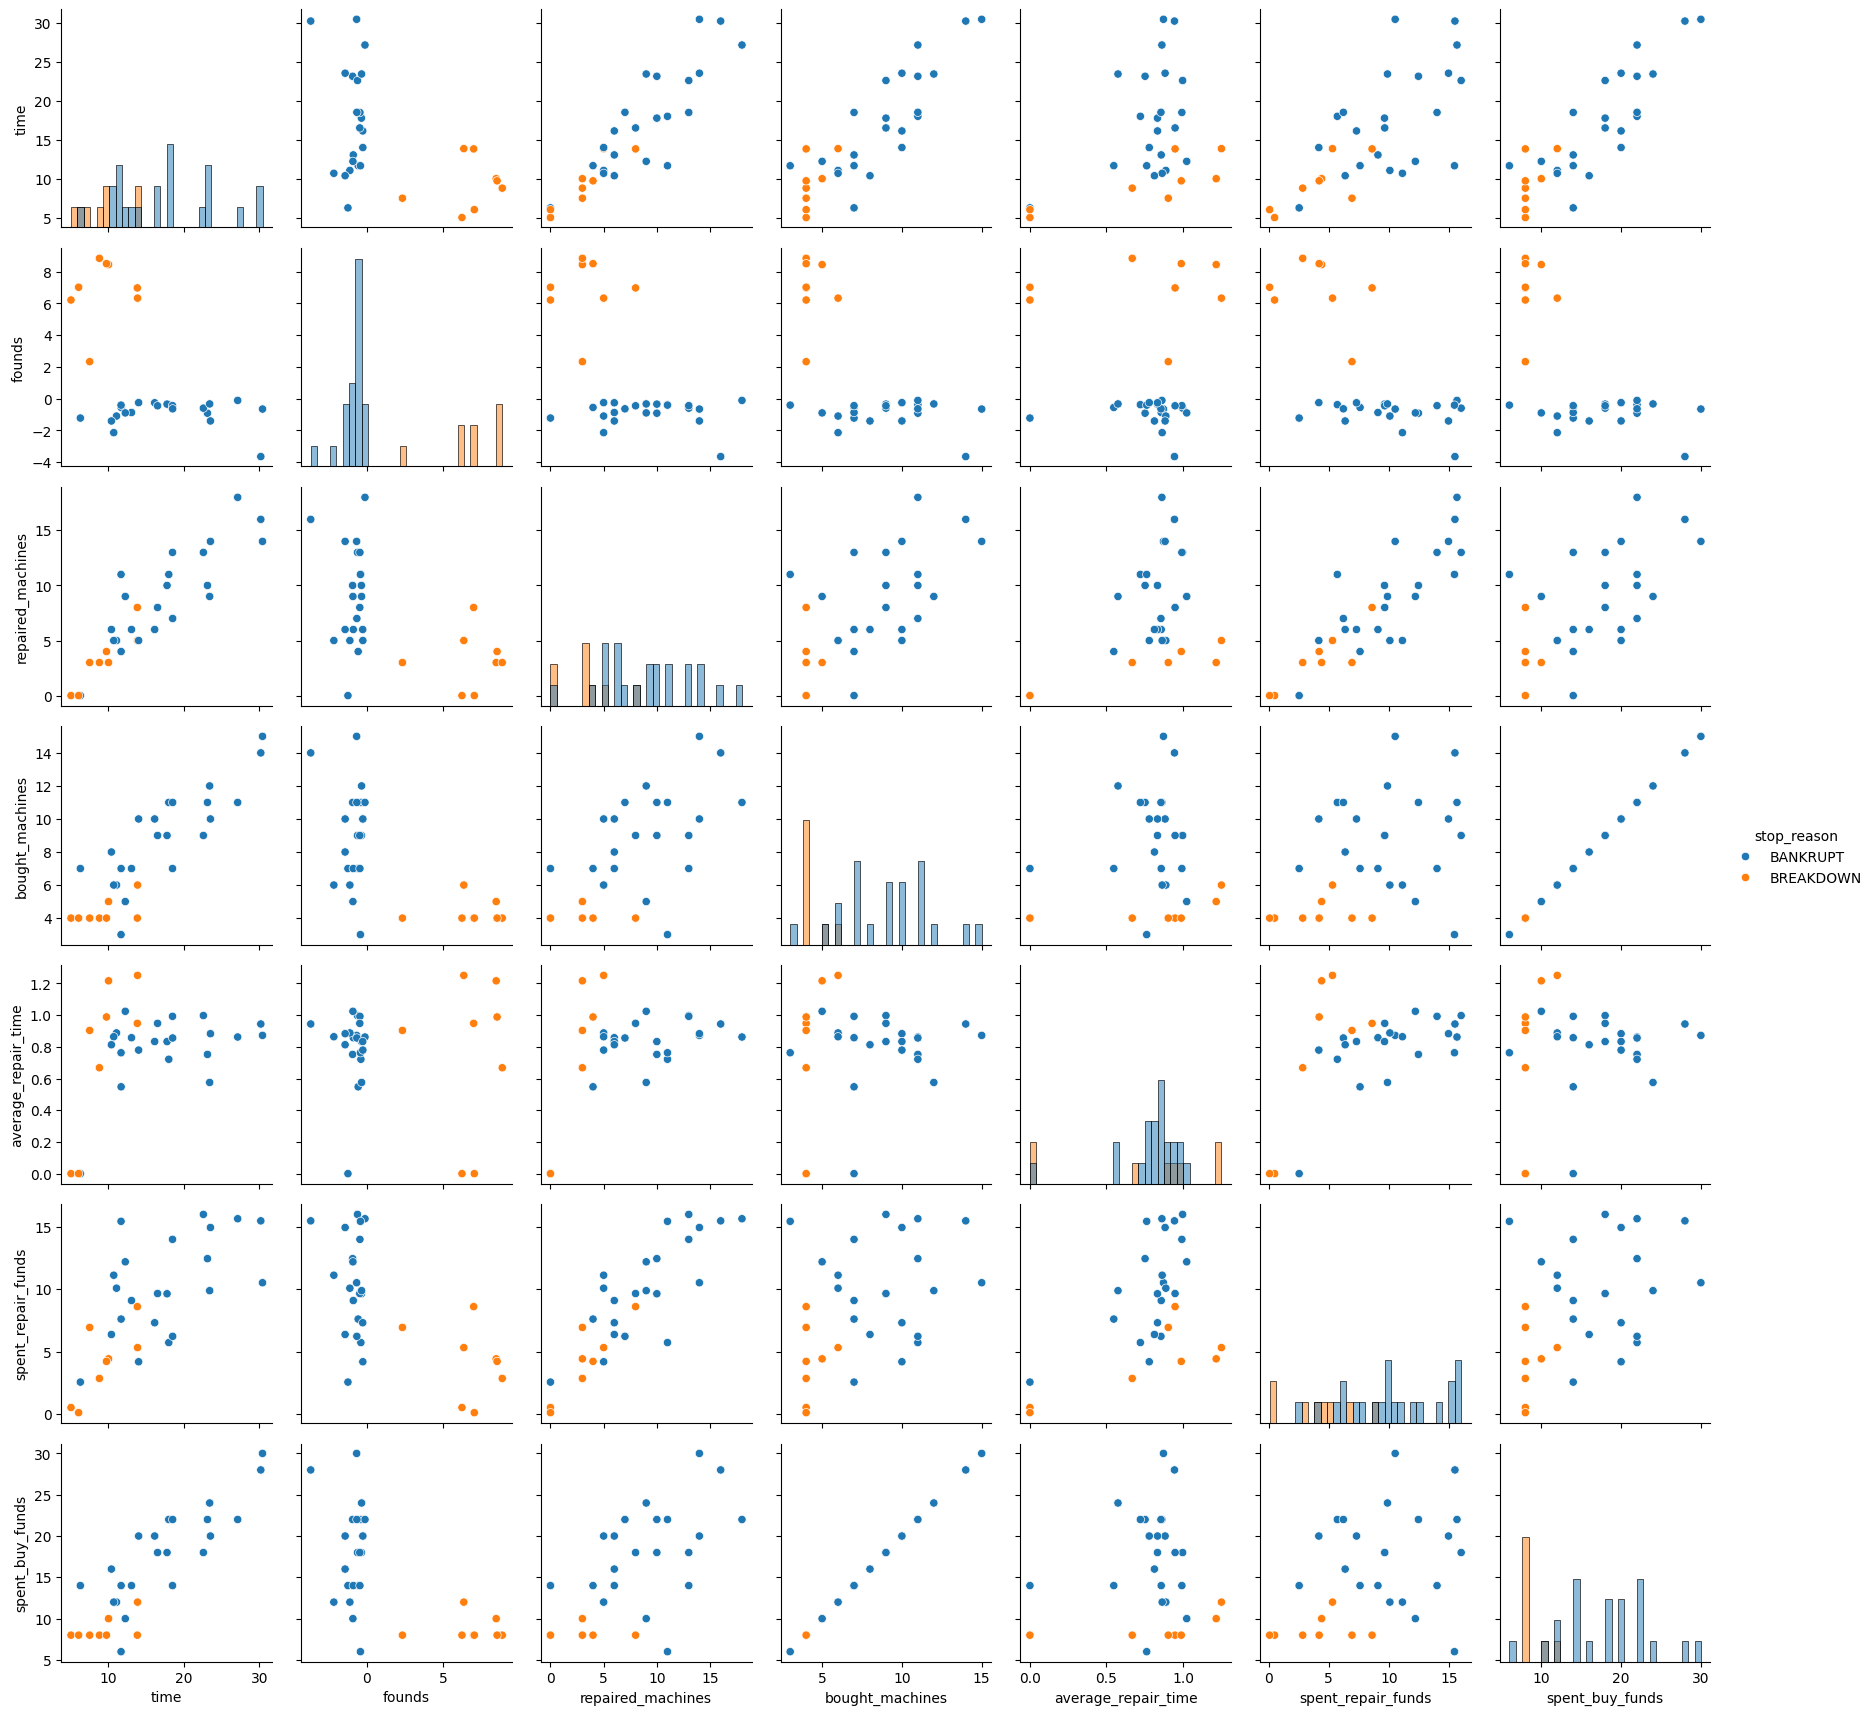

time     founds  repaired_machines  bought_machines  \
count  30.000000  30.000000          30.000000        30.000000   
mean   15.422173   1.191890           7.533333         7.766667   
std     6.978819   3.672778           4.754188         3.244978   
min     5.087115  -3.645468           0.000000         3.000000   
25%    10.510597  -0.887466           4.250000         5.000000   
50%    13.878273  -0.420608           6.500000         7.000000   
75%    18.531754   1.724167          10.750000        10.000000   
max    30.423593   8.845376          18.000000        15.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            30.000000           30.000000        30.000000  
mean              0.786318            8.639684        15.533333  
std               0.305575            4.597379         6.489957  
min               0.000000            0.090945         6.000000  
25%               0.755029            5.417709        10.000000  
50%               0.860058            8.852207        14.000000  
75%               0.947362           11.937862        20.000000  
max               1.251190           16.015459        30.000000

In [12]:
df_3_1 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_dummy, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_1, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_1.describe()

#### 3.2 - Funcion de decision cuadratica que prioriza el tiempo

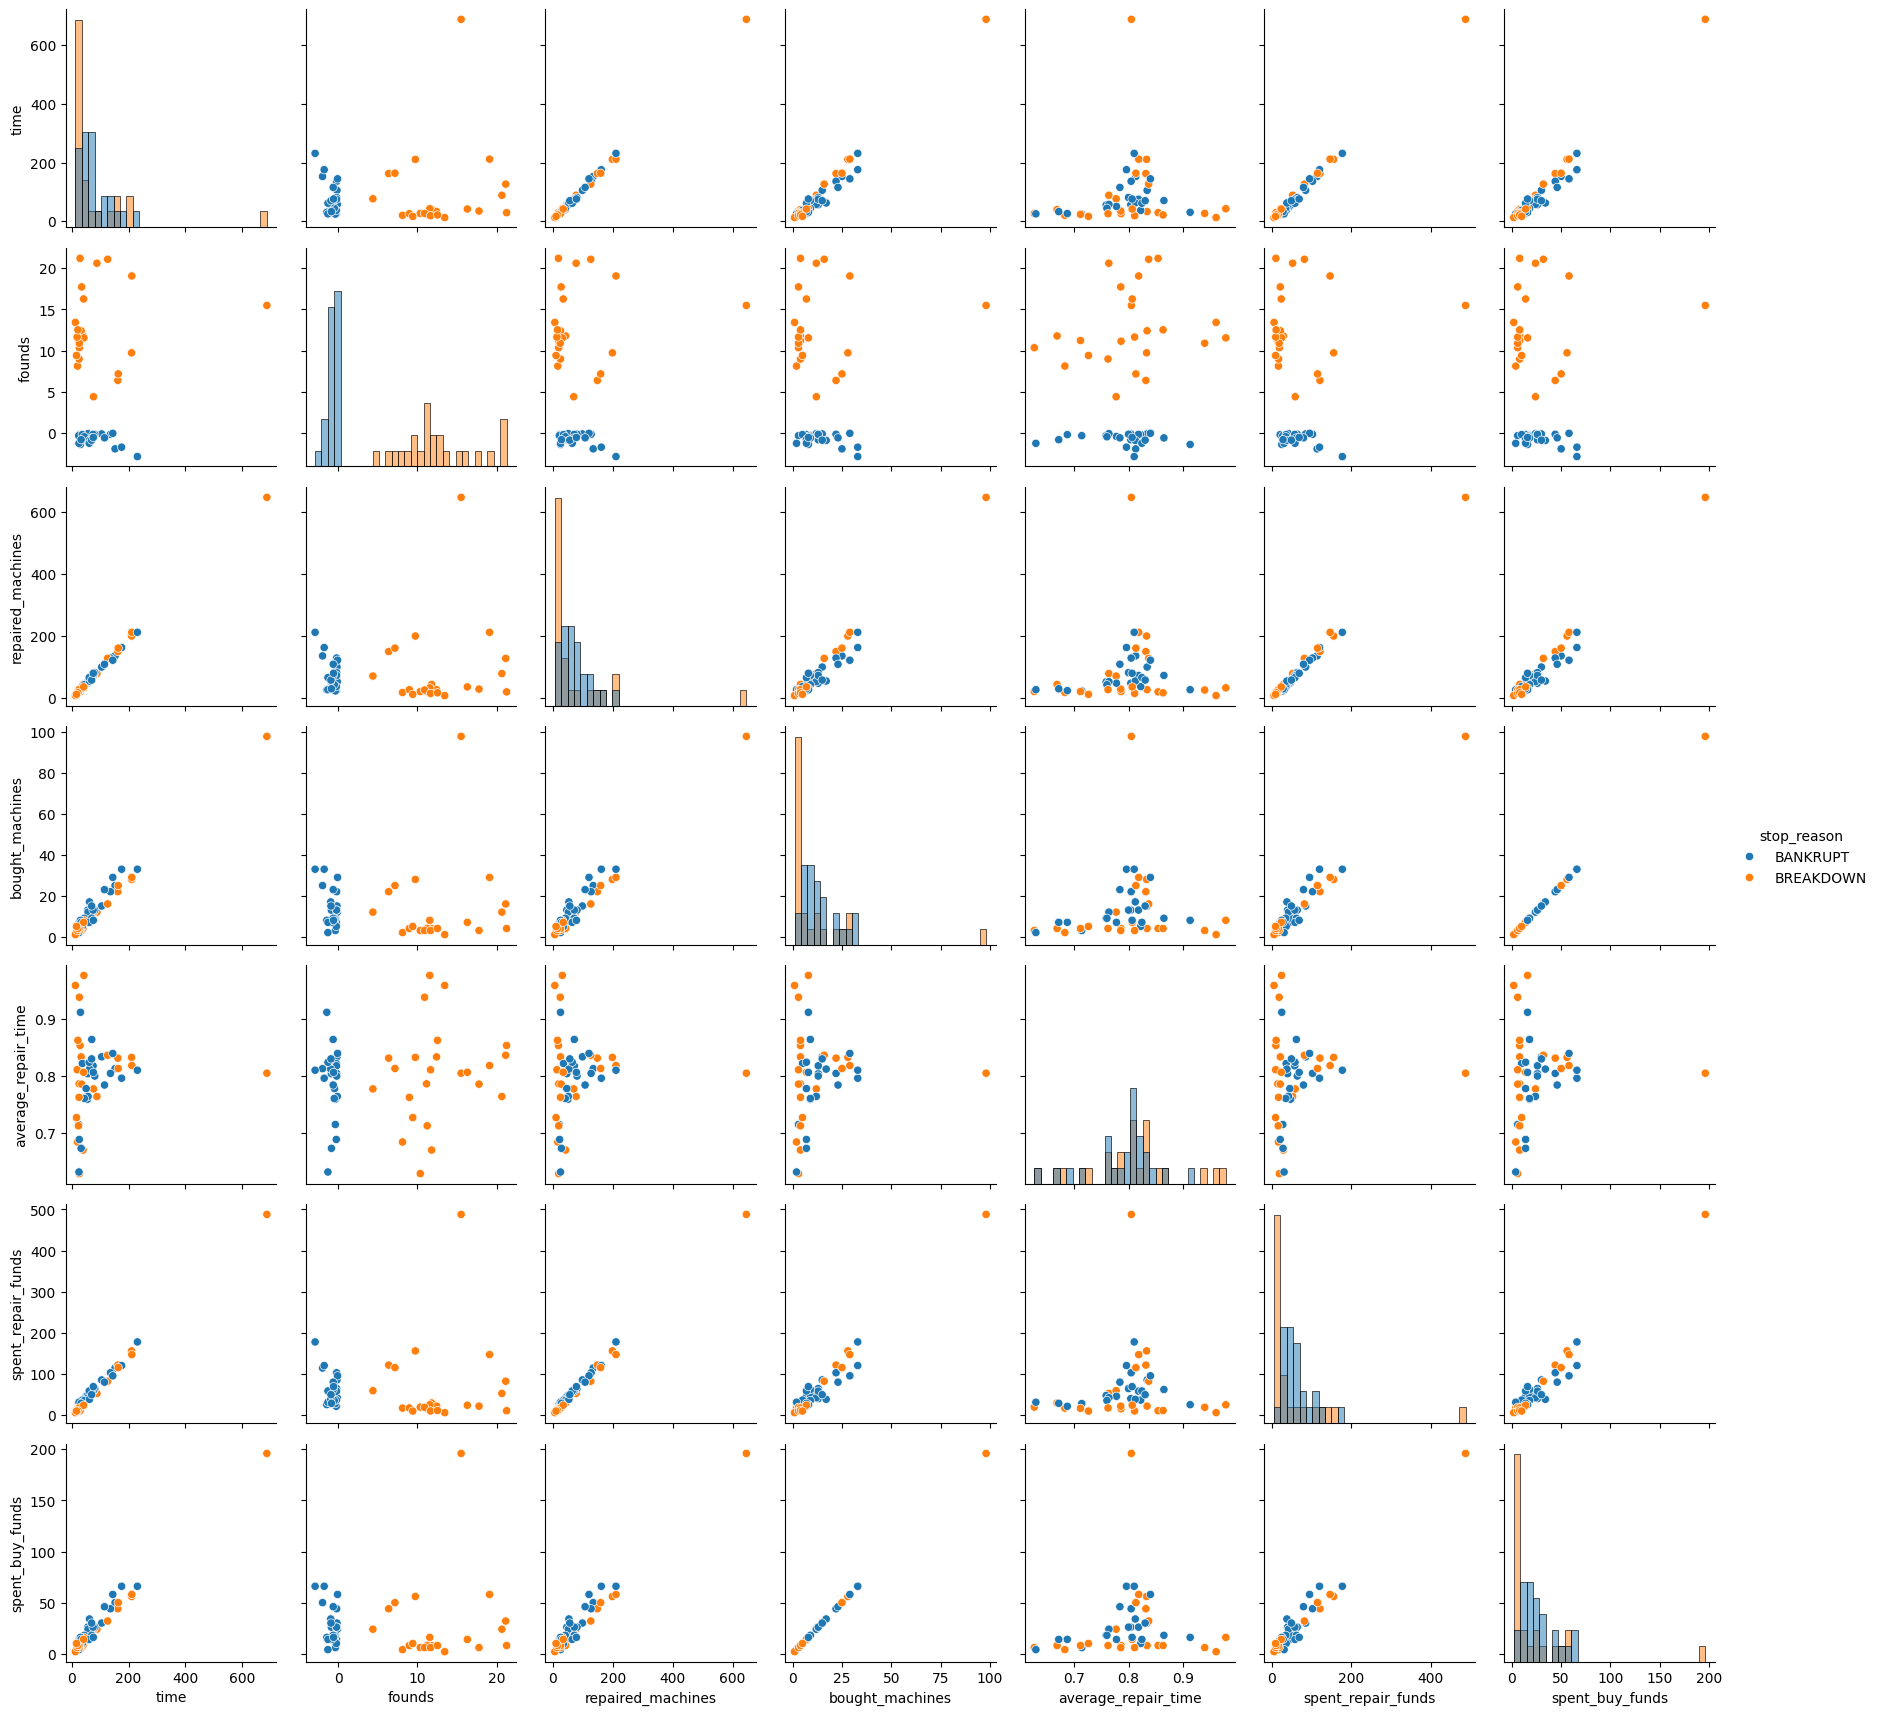

time     founds  repaired_machines  bought_machines  \
count   49.000000  49.000000          49.000000        49.000000   
mean    84.623210   5.795737          78.448980        13.244898   
std    105.429370   7.494866          99.493941        15.295057   
min     12.072980  -2.880792           7.000000         1.000000   
25%     26.169868  -0.556776          26.000000         4.000000   
50%     54.758284  -0.054227          47.000000         8.000000   
75%    105.027949  11.543629          99.000000        16.000000   
max    689.032858  21.210455         646.000000        98.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            49.000000           49.000000        49.000000  
mean              0.796443           62.239180        26.489796  
std               0.073050           75.073722        30.590114  
min               0.628255            5.769394         2.000000  
25%               0.764080           21.570961         8.000000  
50%               0.806485           39.971791        16.000000  
75%               0.831577           79.979822        32.000000  
max               0.977252          488.067486       196.000000

In [13]:
df_3_2 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_sq_time, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_2, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_2.describe()

#### 3.3 - Funcion de decision cuadratica que prioriza el costo

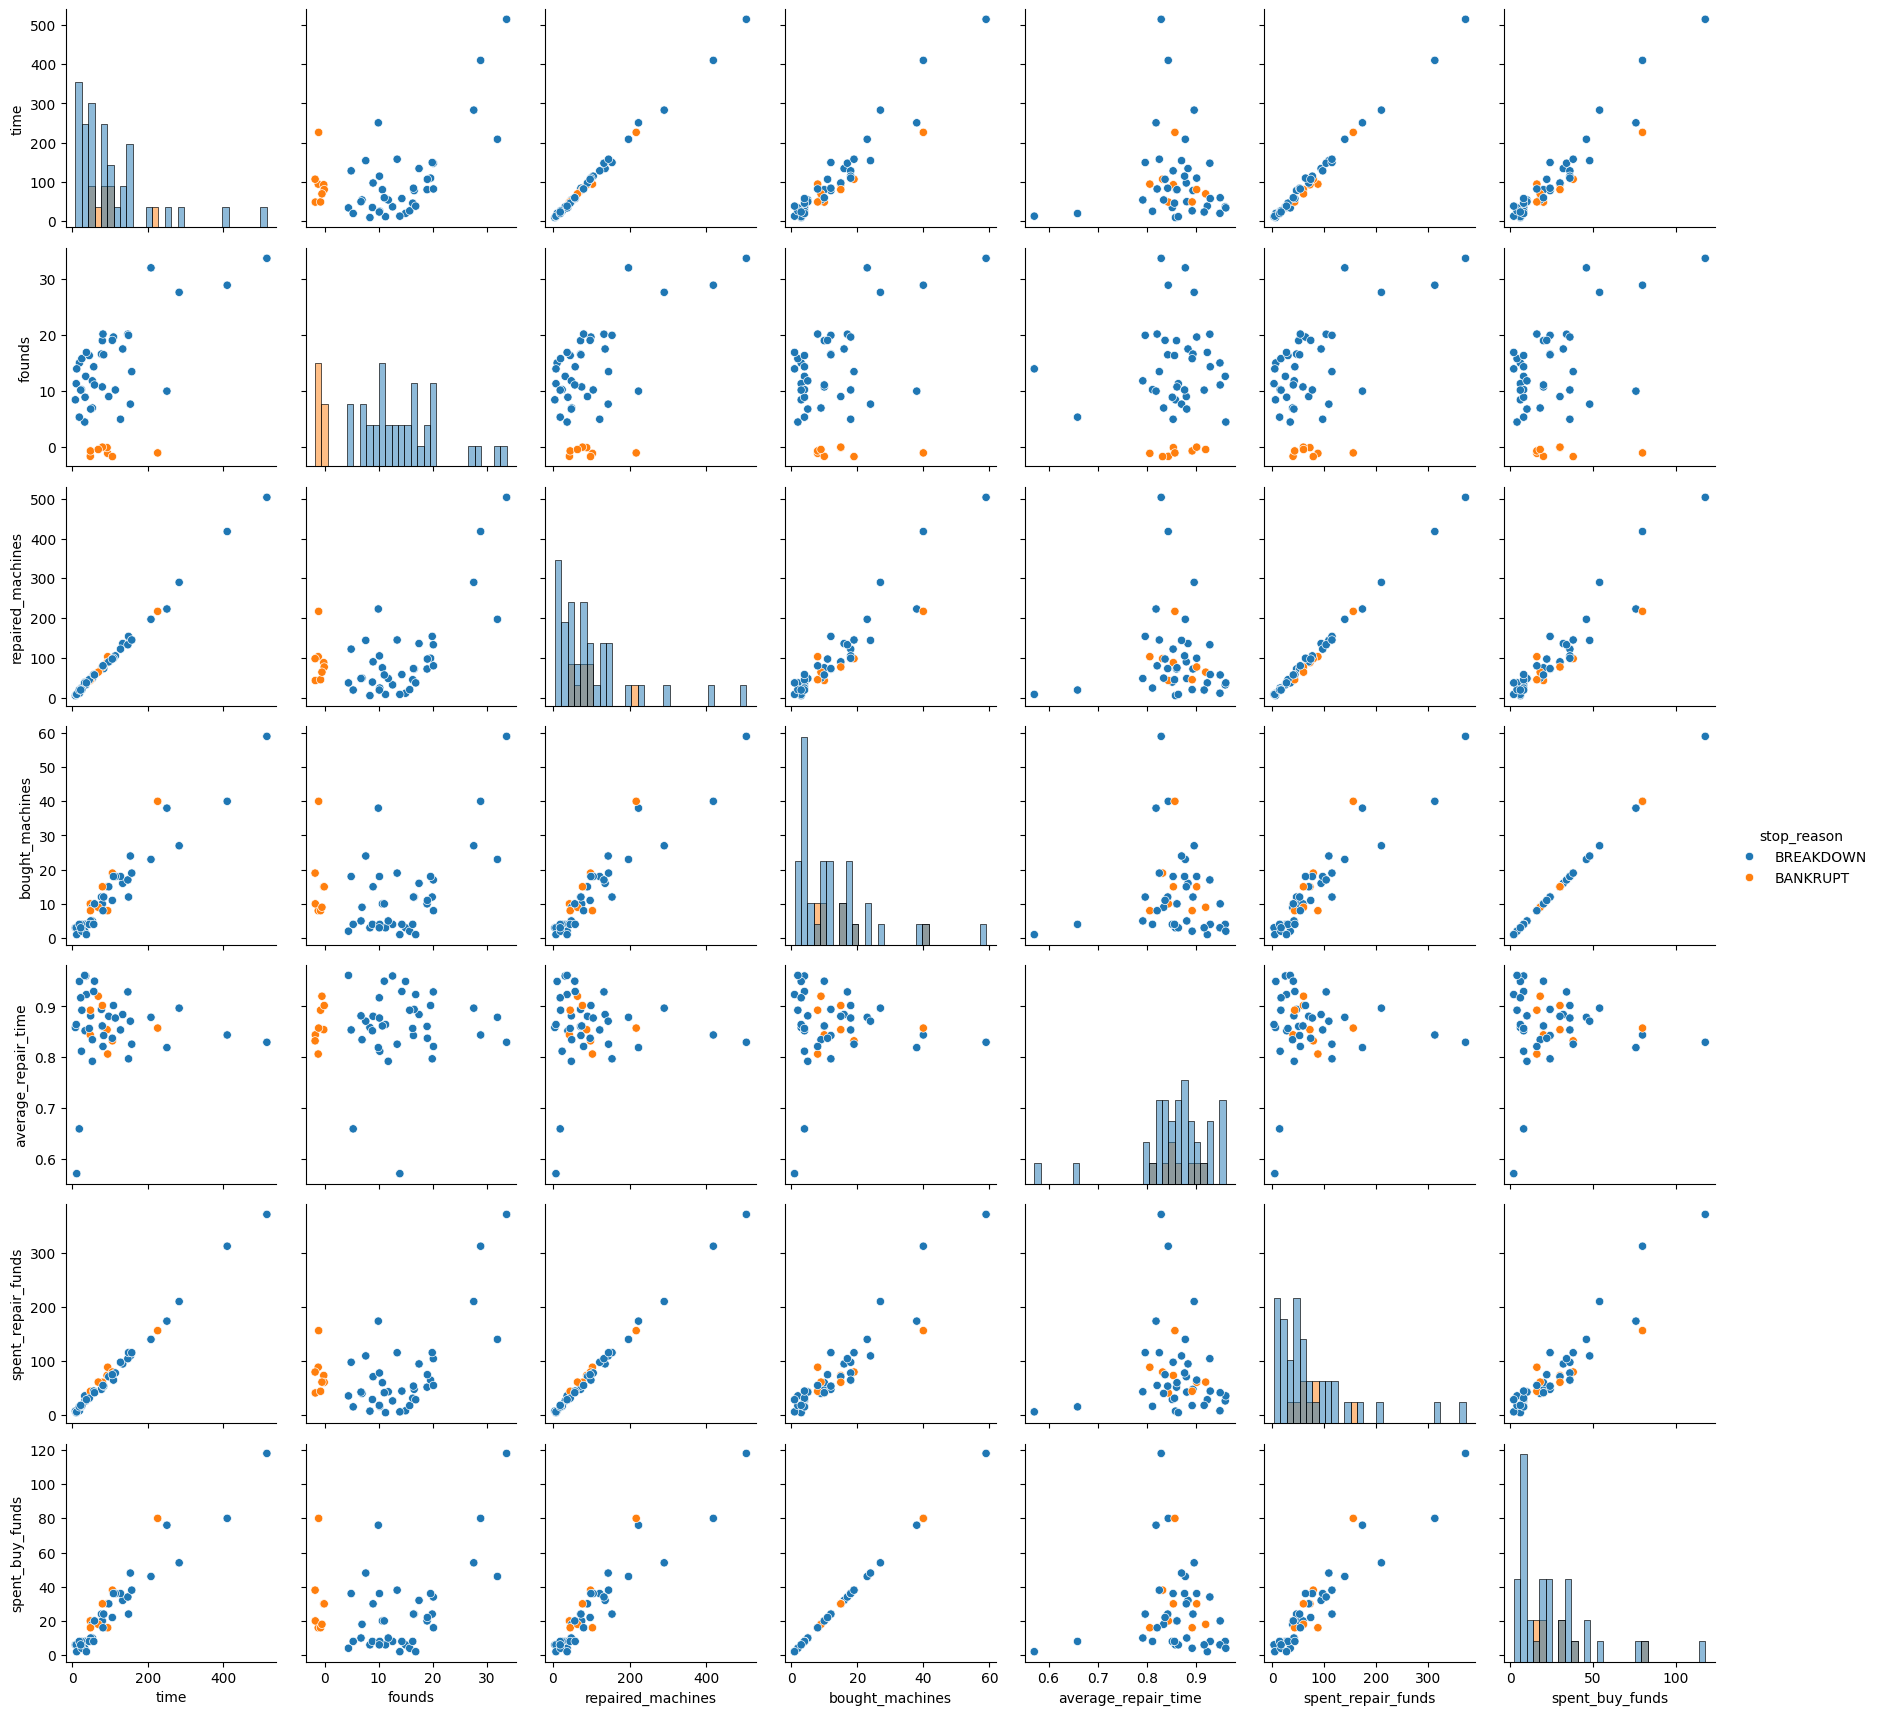

time     founds  repaired_machines  bought_machines  \
count   46.000000  46.000000          46.000000        46.000000   
mean   102.757543  11.920039          98.434783        13.086957   
std    100.933734   8.834858         100.012811        12.012634   
min      8.419473  -1.779001           5.000000         1.000000   
25%     39.514078   6.772888          40.000000         4.000000   
50%     79.679633  11.153112          72.500000        10.000000   
75%    124.374720  16.785900         117.750000        17.750000   
max    514.959488  33.697925         504.000000        59.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            46.000000           46.000000        46.000000  
mean              0.860449           74.792985        26.173913  
std               0.068802           73.747379        24.025269  
min               0.570941            3.725146         2.000000  
25%               0.835280           31.622208         8.000000  
50%               0.861227           53.687711        20.000000  
75%               0.896106           92.787935        35.500000  
max               0.961199          372.295614       118.000000

In [14]:
df_3_3 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_sq_cost, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_3, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_3.describe()

#### 3.4 - Funcion de decision cuadratica que prioriza el producto del tiempo y el costo

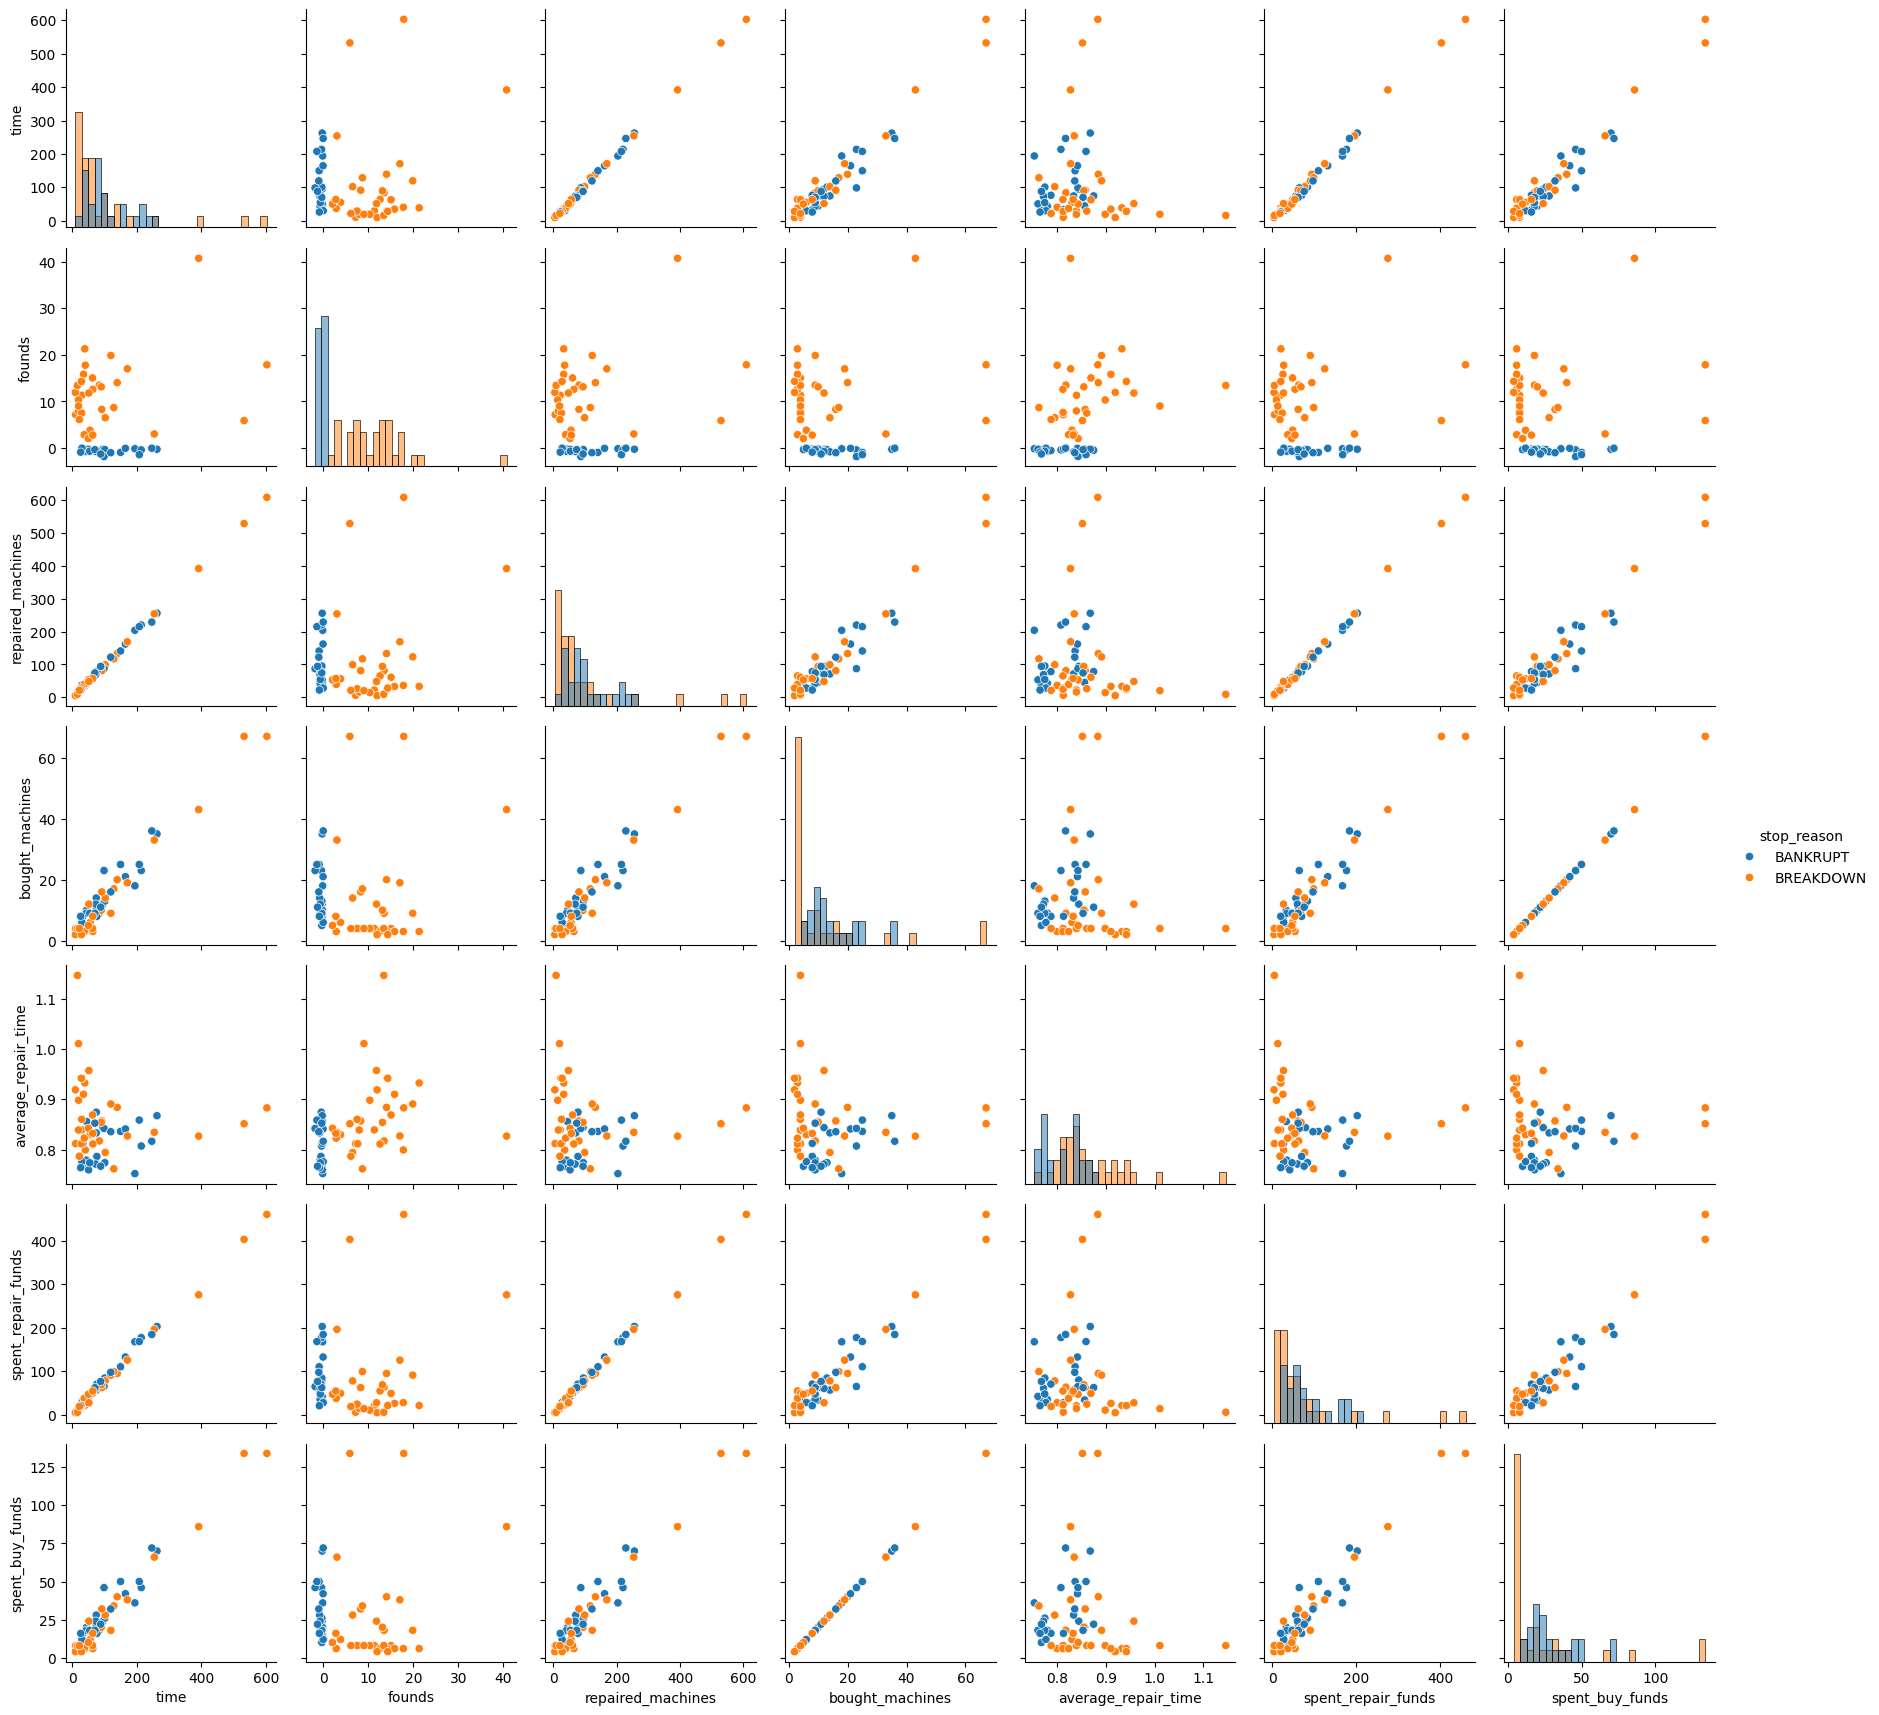

time     founds  repaired_machines  bought_machines  \
count   59.000000  59.000000          59.000000        59.000000   
mean   103.180578   6.463985         101.254237        13.440678   
std    115.848474   8.185465         116.680021        13.730499   
min      9.746290  -1.827789           5.000000         2.000000   
25%     31.723488  -0.332172          30.500000         4.000000   
50%     63.778443   3.833555          65.000000         9.000000   
75%    119.543892  12.276625         119.500000        16.500000   
max    602.724028  40.726613         609.000000        67.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count            59.000000           59.000000        59.000000  
mean              0.843131           79.883175        26.881356  
std               0.067423           87.802436        27.460997  
min               0.752441            4.747535         4.000000  
25%               0.803324           26.698820         8.000000  
50%               0.835611           54.588253        18.000000  
75%               0.863852           92.791676        33.000000  
max               1.145900          459.961477       134.000000

In [15]:
df_3_4 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_sq_all, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_4, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_4.describe()

#### 3.5 - A los datos de mejor desempeño le activamos SJF para ver si mejoran

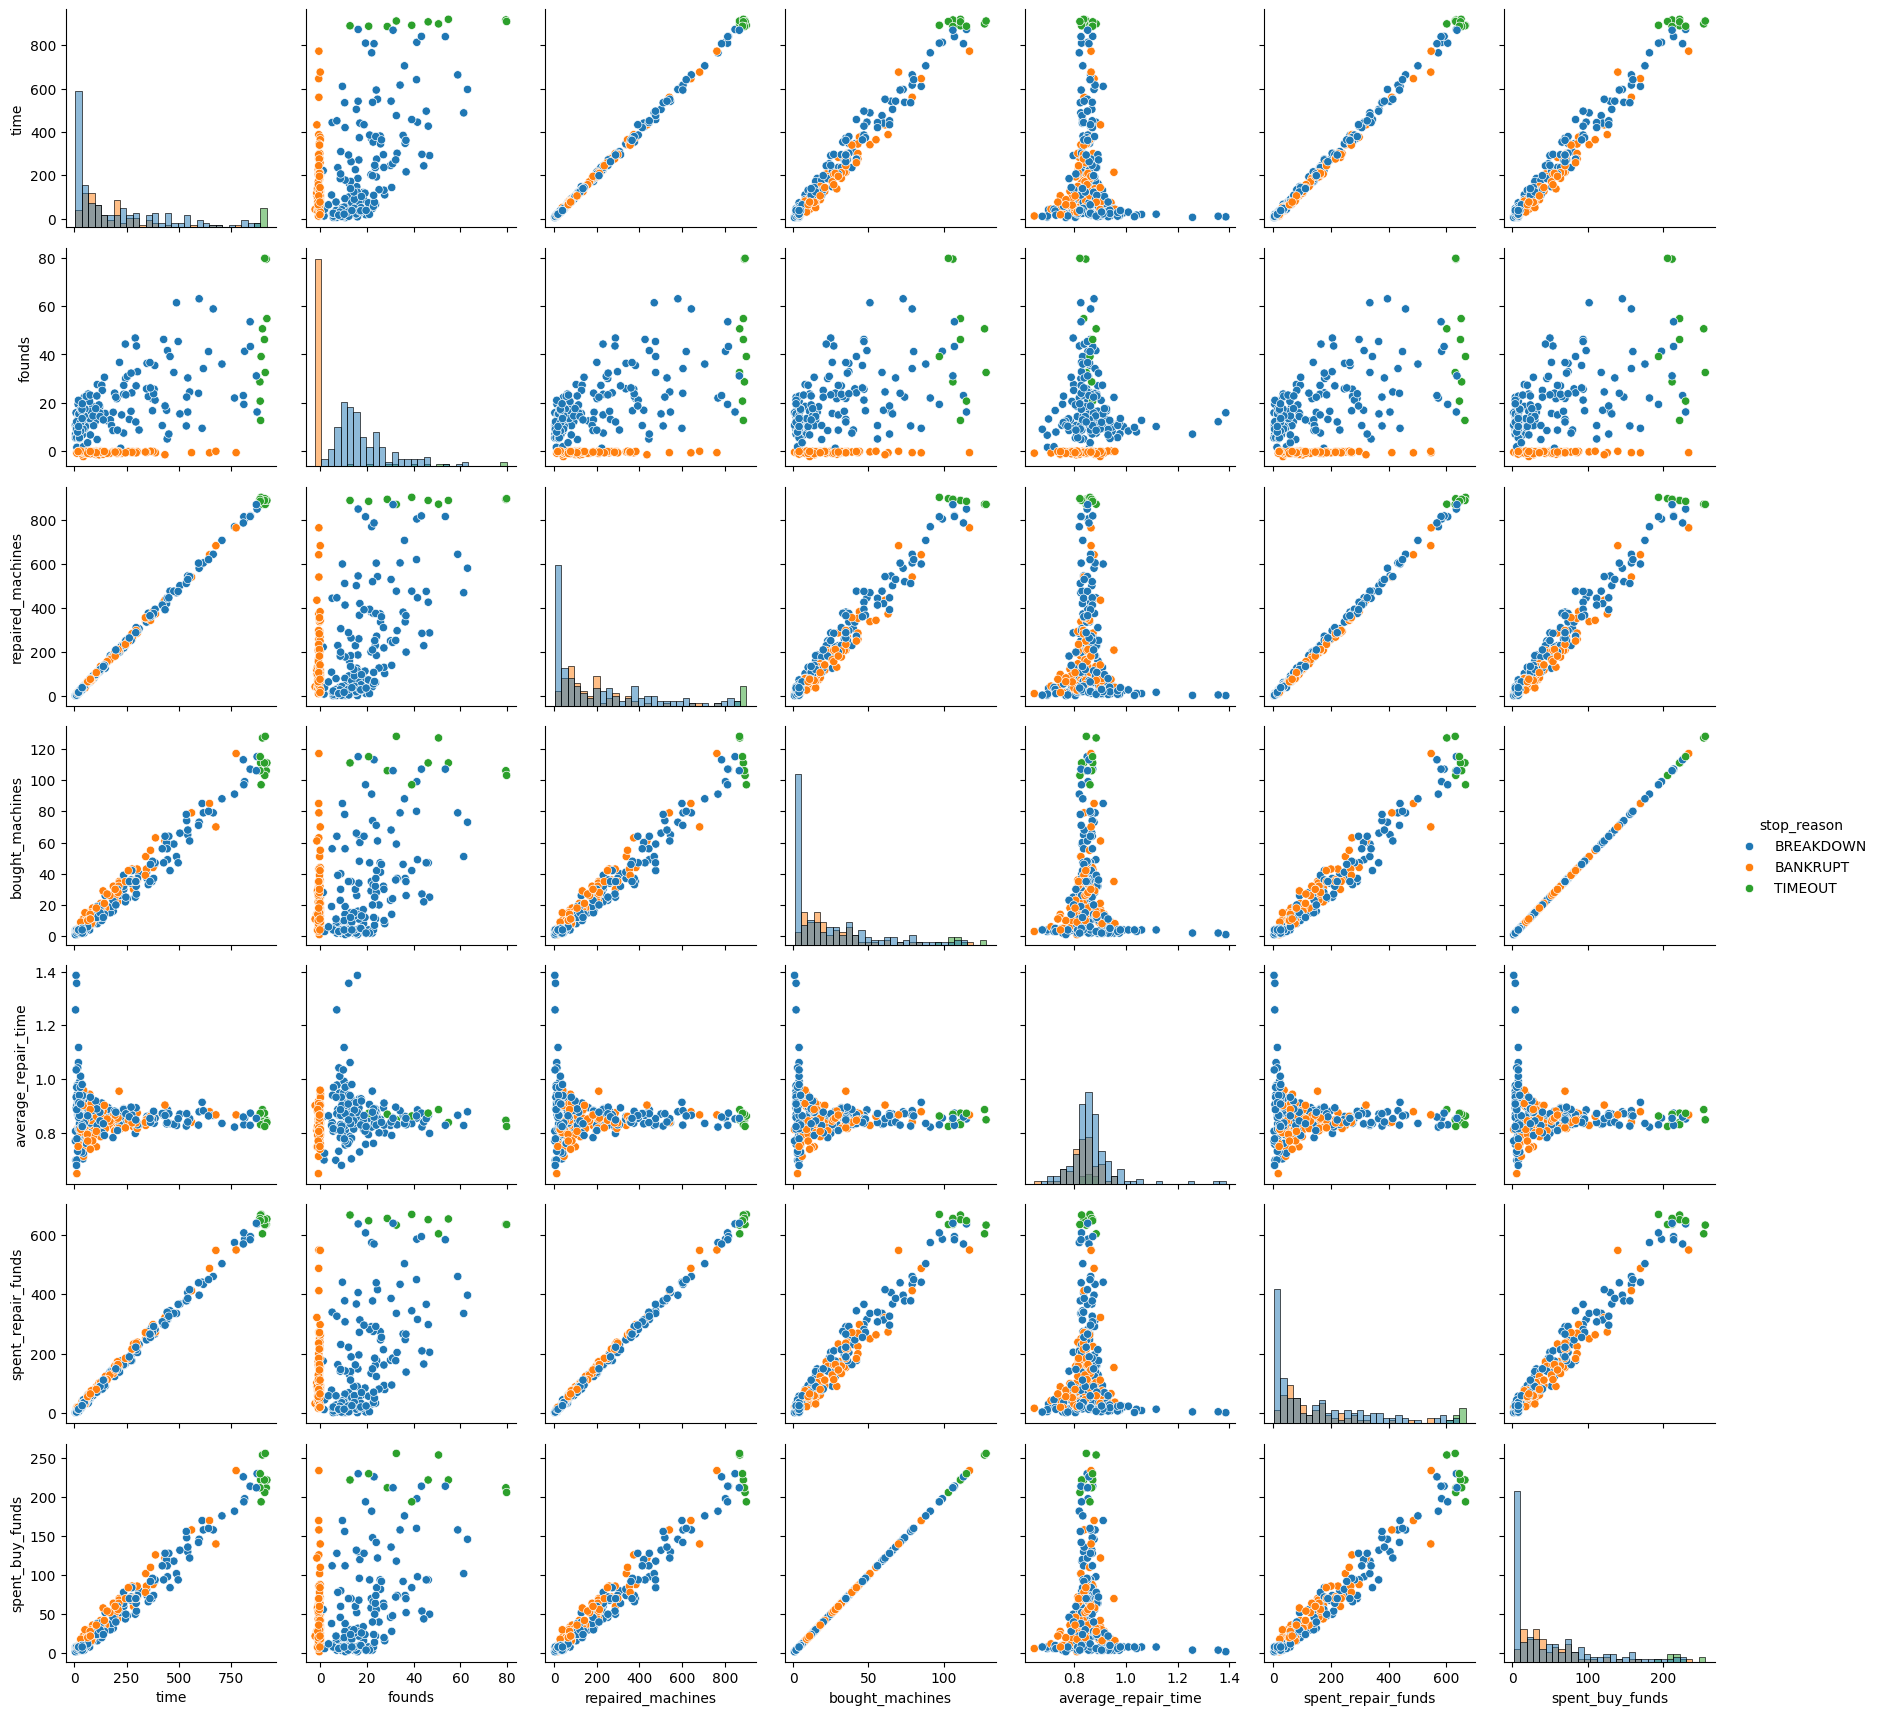

time      founds  repaired_machines  bought_machines  \
count  262.000000  262.000000         262.000000       262.000000   
mean   221.805216   13.449423         217.263359        28.290076   
std    243.219347   15.068082         240.630166        30.455416   
min      5.544233   -2.314343           3.000000         1.000000   
25%     38.663064   -0.200674          37.250000         5.000000   
50%    122.735522   10.569798         119.000000        16.000000   
75%    301.675786   20.626628         304.000000        37.000000   
max    919.036113   79.797876         901.000000       128.000000   

       average_repair_time  spent_repair_funds  spent_buy_funds  
count           262.000000          262.000000       262.000000  
mean              0.858245          161.834072        56.580153  
std               0.079893          175.108261        60.910833  
min               0.647937            1.973820         2.000000  
25%               0.823280           28.292364        10.000000  
50%               0.853153           89.545777        32.000000  
75%               0.883099          234.525364        74.000000  
max               1.386113          667.620710       256.000000

In [29]:
df_3_5 = stop_criteria(20, # cantidad de maquinas
                        5, # cantidad de repuestos
                        10, # presupuesto inicial
                        2, # costo de compra
                        1, # tiempo de entrega
                        profit_function_sn_lg, # funcion de ganancia
                        decition_function_sq_cost, # funcion de decicion
                        event_distribution, # distribucion de las rupturas
                        repair_time_distribution, # distribucion de los tiempos de reparacion
                        repair_cost_distribution, # distribucion de los costos de reparacion
                        1000, sjf=True) # cantidad maxima de pasos de la simulacion

plot = sns.PairGrid(df_3_5, hue='stop_reason')
plot.map_diag(sns.histplot, bins=30)
plot.map_offdiag(sns.scatterplot)
plot.add_legend()

plt.show()

df_3_5.describe()

## Pruebas de hipotesis

In [16]:
ALPHA = 0.05

In [24]:
time_1_0 = df_1_0.time.mean()
time_1_1 = df_1_1.time.mean()
time_1_2 = df_1_2.time.mean()

print(f'Tiempo promedio de 1.0: {time_1_0}')
print(f'Tiempo promedio de 1.1: {time_1_1}')
print(f'Tiempo promedio de 1.2: {time_1_2}')

timeout_rel_1_0 = sum(df_1_0.stop_reason == TIMEOUT) / len(df_1_0.stop_reason)
timeout_rel_1_1 = sum(df_1_1.stop_reason == TIMEOUT) / len(df_1_1.stop_reason)
timeout_rel_1_2 = sum(df_1_2.stop_reason == TIMEOUT) / len(df_1_2.stop_reason)

print(f'Proporcion de TIMEOUT\'s en 1.0: {timeout_rel_1_0}')
print(f'Proporcion de TIMEOUT\'s en 1.1: {timeout_rel_1_1}')
print(f'Proporcion de TIMEOUT\'s en 1.1: {timeout_rel_1_2}')

Tiempo promedio de 1.0: 344.0418139004235
Tiempo promedio de 1.1: 884.3587205297997
Tiempo promedio de 1.2: 739.1954942959153
Proporcion de TIMEOUT's en 1.0: 0.07647058823529412
Proporcion de TIMEOUT's en 1.1: 1.0
Proporcion de TIMEOUT's en 1.1: 0.66996699669967


In [18]:
time_1_3 = df_1_3.time.mean()
time_2_0 = df_2_0.time.mean()

print(f'Tiempo promedio de 1.3: {time_1_3}')
print(f'Tiempo promedio de 2.0: {time_2_0}')

timeout_rel_1_3 = sum(df_1_3.stop_reason == TIMEOUT) / len(df_1_3.stop_reason)
timeout_rel_2_0 = sum(df_2_0.stop_reason == TIMEOUT) / len(df_2_0.stop_reason)

print(f'Proporcion de TIMEOUT\'s en 1.3: {timeout_rel_1_3}')
print(f'Proporcion de TIMEOUT\'s en 2.0: {timeout_rel_2_0}')

t_statistic, p_value = stats.kruskal(df_1_3.time, df_2_0.time)

if p_value < ALPHA:
    print("Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media")
else:
    print("Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana")

p_value

Tiempo promedio de 1.3: 328.86283383740715
Tiempo promedio de 2.0: 221.42154629947322
Proporcion de TIMEOUT's en 1.3: 0.08280254777070063
Proporcion de TIMEOUT's en 2.0: 0.028985507246376812
Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media


9.194274212335649e-07

In [19]:
founds_1_3 = df_1_3.founds.mean()
founds_2_0 = df_2_0.founds.mean()

print(f'Fondos promedio de 1.3: {founds_1_3}')
print(f'Fondos promedio de 2.0: {founds_2_0}')

t_statistic, p_value = stats.kruskal(df_1_3.founds, df_2_0.founds)

if p_value < ALPHA:
    print("Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media")
else:
    print("Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana")

p_value

Fondos promedio de 1.3: 2932.9378949317825
Fondos promedio de 2.0: 1998.6151591469602
Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media


1.5002275708980621e-06

In [36]:
t_statistic, p_value = stats.ttest_ind(df_2_0.time, df_2_1.time)

if p_value < ALPHA:
    print("Ambos tiempos tienen distintas medias")
else:
    print("Ambos tiempos tienen la misma media")

print(f'Media del tiempo en 2.0: {df_2_0.time.mean()}')
print(f'Media del tiempo en 2.1: {df_2_1.time.mean()}')

Ambos tiempos tienen distintas medias
Media del tiempo en 2.0: 221.42154629947322
Media del tiempo en 2.1: 101.76587535795942


In [37]:
t_statistic, p_value = stats.ttest_ind(df_2_0.founds, df_2_1.founds)

if p_value < ALPHA:
    print("Ambos tiempos tienen distintas medias")
else:
    print("Ambos tiempos tienen la misma media")

print(f'Media de las ganancias en 2.0: {df_2_0.founds.mean()}')
print(f'Media de las ganancias en 2.1: {df_2_1.founds.mean()}')

Ambos tiempos tienen distintas medias
Media de las ganancias en 2.0: 1998.6151591469602
Media de las ganancias en 2.1: 7.520688525541239


In [44]:
t_statistic, p_value = stats.kruskal(df_3_0.time, df_3_1.time, df_3_2.time, df_3_3.time, df_3_4.time)

if p_value < ALPHA:
    print("Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media")
else:
    print("Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana")
p_value

Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media


1.6398796592688834e-12

In [45]:
t_statistic, p_value = stats.kruskal(df_3_0.time, df_3_2.time, df_3_3.time, df_3_4.time)

if p_value < ALPHA:
    print("Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media")
else:
    print("Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana")

p_value

Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana


0.41053252795321593

In [46]:
t_statistic, p_value = stats.kruskal(df_3_0.founds, df_3_2.founds, df_3_3.founds, df_3_4.founds)

if p_value < ALPHA:
    print("Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media")
else:
    print("Aceptamos la hipotesis nula, luego, los datos tienen la misma mediana")

print(p_value)

Rechazamos la hipotesis nula, luego, no todos los datos tienen la misma media
0.006008471255317017


In [27]:
opt_time = df_3_2.founds.mean()
opt_cost = df_3_3.founds.mean() # la estrategia de escoger priorizando el precio optimiza la media de las ganancias
opt_all = df_3_4.founds.mean()
opt_linl = df_2_1.founds.mean()

print(opt_time, opt_cost, opt_all, opt_linl)

5.795737228621135 11.920038807736642 6.4639846761121555 7.520688525541239


In [28]:
opt_time = df_3_2.time.mean()
opt_cost = df_3_3.time.mean() # la estrategia de escoger priorizando el precio tambien optimiza la media del tiempo
opt_all = df_3_4.time.mean()
opt_linl = df_2_1.time.mean()

print(opt_time, opt_cost, opt_all, opt_linl)

84.62320974358546 102.75754337438511 103.18057779255848 101.76587535795942


In [32]:
t_statistic, p_value = stats.ttest_ind(df_3_5.founds, df_3_3.founds)

if p_value < ALPHA:
    print("Ambos tiempos tienen distintas medias")
else:
    print("Ambos tiempos tienen la misma media")

Ambos tiempos tienen la misma media


In [48]:
t_statistic, p_value = stats.ttest_ind(df_3_5.time, df_3_3.time)

if p_value < ALPHA:
    print("Ambos tiempos tienen distintas medias")
else:
    print("Ambos tiempos tienen la misma media")

p_value

Ambos tiempos tienen distintas medias


0.0012100251184757507

In [31]:
print(f'Fondos en 3.3: {df_3_3.founds.mean():.4f} Fondos en 3.5: {df_3_5.founds.mean():.4f}')
print(f'Tiempo en 3.3: {df_3_3.time.mean():.4f} Time en 3.5: {df_3_5.time.mean():.4f}')

Fondos en 3.3: 11.9200 Fondos en 3.5: 13.4494
Tiempo en 3.3: 102.7575 Time en 3.5: 221.8052
